In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation
import matplotlib as mpl
font = {'size'   : 12}

mpl.rc('font', **font)
%matplotlib ipympl

import numpy as np
import pandas as pd
import pims
import networkx as nx

from scipy.spatial import KDTree, cKDTree, Voronoi, voronoi_plot_2d, ConvexHull
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import time
import joblib
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory, WindowType, DiffMethod
import yupi.graphics as yg
import yupi.stats as ys
from yupi.transformations import subsample

from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx 
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import graph_tool.all as gt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

show_verb = False
run_windowed_analysis = True
plot_verb = True
animated_plot_verb = False
save_verb = True
run_analysis_verb = True

In [2]:
# IMPORT FUNCTIONS
def get_smooth_trajs(trajs, nDrops, windLen, orderofPoly):
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    ret = trajs.copy()
    for i in range(nDrops):
        ret.loc[ret.particle == i, "x"] = savgol_filter(trajs.loc[trajs.particle == i].x.values, windLen, orderofPoly)
        ret.loc[ret.particle == i, "y"] = savgol_filter(trajs.loc[trajs.particle == i].y.values, windLen, orderofPoly)    
    return ret

def compute_eccentricity(points):
    centroid = np.mean(points, axis=0)
    distances = np.linalg.norm(points - centroid, axis=1)
    eccentricity = np.std(distances) / np.mean(distances)
    return eccentricity

def motif_search(mofitList, sizeList, g):
    counts = np.zeros(len(mofitList), dtype=int)
    for i, motif in enumerate(mofitList):
        _, temp = gt.motifs(g, sizeList[i], motif_list = [motif])
        counts[i] = temp[0]
    return counts

def powerLawFit(f, x, nDrops, yerr):
    if nDrops == 1:
        ret = np.zeros((2, 2))
        ret[0], pcov = curve_fit(powerLaw, x, f, p0 = [1., 1.])
        ret[1] = np.sqrt(np.diag(pcov))
        fit = ret[0, 0] * x**ret[0, 1]
    else:
        fit = np.zeros((nDrops, f.shape[0])) 
        ret = np.zeros((nDrops, 2, 2))
        for i in range(nDrops):
            if yerr is None:
                ret[i, 0], pcov = curve_fit(powerLaw, x, f[i], p0 = [1., 1.])
            else:
                ret[i, 0], pcov = curve_fit(powerLaw, x, f[i], p0 = [1., 1.], sigma = yerr)
            ret[i, 1] = np.sqrt(np.diag(pcov))
            fit[i] = ret[i, 0, 0] * x**ret[i, 0, 1]
    return fit, ret 

def get_imsd(trajs, pxDimension, fps, maxLagtime, fit_range):
    imsd = tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
    # fit the IMSD in the fit_range
    id_start = np.where(imsd.index == fit_range[0])[0][0]
    id_end = np.where(imsd.index == fit_range[-1])[0][0] + 1
    imsd_to_fit = imsd.iloc[id_start:id_end]
    fit, pw_exp = powerLawFit(imsd_to_fit, imsd_to_fit.index, nDrops, None)
    return imsd, fit, pw_exp


def get_emsd(imsd, fps, red_mask, nDrops, fit_range):
    id_start = np.where(imsd.index == fit_range[0])[0][0]
    id_end = np.where(imsd.index == fit_range[-1])[0][0] + 1
    MSD = np.array(imsd)
    MSD_b = [MSD[:, ~red_mask].mean(axis = 1),
                MSD[:, ~red_mask].std(axis = 1)]
    MSD_r = [MSD[:, red_mask].mean(axis = 1),
                MSD[:, red_mask].std(axis = 1)]
    # fit the EMSD in the fit_range
    fit_b, pw_exp_b = powerLawFit(MSD_b[0][id_start:id_end], fit_range, 1, MSD_b[1][id_start:id_end])
    fit_r, pw_exp_r = powerLawFit(MSD_r[0][id_start:id_end], fit_range, 1, MSD_r[1][id_start:id_end])
    results = {"fit_b": fit_b, "pw_exp_b": pw_exp_b, "fit_r": fit_r, "pw_exp_r": pw_exp_r}
    return MSD_b, MSD_r, results


def get_imsd_windowed(nSteps, startFrames, endFrames, trajs, pxDimension, fps, maxLagtime, fit_range):
    MSD_wind = []
    # fit region of the MSD
    fit_wind = np.zeros((nSteps, nDrops, len(fit_range)))
    pw_exp_wind = np.zeros((nSteps, nDrops, 2, 2))
    for i in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[i], endFrames[i])]
        temp, fit_wind[i], pw_exp_wind[i], = get_imsd(trajs_wind, pxDimension, fps, maxLagtime, fit_range)
        MSD_wind.append(temp)
    return MSD_wind, fit_wind, pw_exp_wind


def get_emsd_windowed(imsd, x, fps, red_particle_idx, nSteps, maxLagtime, fit_range):
    id_start = np.where(imsd[0].index == fit_range[0])[0][0]
    id_end = np.where(imsd[0].index == fit_range[-1])[0][0] + 1
    EMSD_wind = np.array(imsd)
    EMSD_wind_b = [EMSD_wind[:, :, ~red_mask].mean(axis = 2), 
                    EMSD_wind[:, :, ~red_mask].std(axis = 2)]
    EMSD_wind_r = [EMSD_wind[:, :, red_mask].mean(axis = 2), 
                    EMSD_wind[:, :, red_mask].std(axis = 2)]

    # diffusive region of the MSD
    fit_wind_b = np.zeros((nSteps, len(fit_range)))
    pw_exp_wind_b = np.zeros((nSteps, 2, 2))
    fit_wind_r = np.zeros((nSteps, len(fit_range)))
    pw_exp_wind_r = np.zeros((nSteps, 2, 2))
    
    for i in tqdm(range(nSteps)):
        fit_wind_b[i], pw_exp_wind_b[i] = powerLawFit(EMSD_wind_b[0][i, id_start:id_end], x, 1, EMSD_wind_b[1][i, id_start:id_end])
        fit_wind_r[i], pw_exp_wind_r[i] = powerLawFit(EMSD_wind_r[0][i, id_start:id_end], x, 1, EMSD_wind_r[1][i, id_start:id_end])
    
    results = {"fit_wind_b":fit_wind_b, "pw_exp_wind_b":pw_exp_wind_b, "fit_wind_r":fit_wind_r,\
                            "pw_exp_wind_r":pw_exp_wind_r}

    return EMSD_wind_b, EMSD_wind_r, results


# get trajectories
def get_trajs(nDrops, red_particle_idx, trajs, subsample_factor, fps):
    blueTrajs = []
    redTrajs = []
    for i in range(0, nDrops):
        if i in red_particle_idx:
            p = trajs.loc[trajs.particle == i, ["x","y"]][::subsample_factor]
            redTrajs.append(Trajectory(p.x, p.y, dt = 1/fps*subsample_factor, traj_id=i, diff_est={"method":DiffMethod.LINEAR_DIFF, 
                                                                                  "window_type": WindowType.CENTRAL}))
        else:
            p = trajs.loc[trajs.particle == i, ["x","y"]][::subsample_factor]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/fps*subsample_factor, traj_id=i))
    return blueTrajs, redTrajs


# get speed distributions windowed in time
def speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajs, subsample_factor, fps):
    v_blue_wind = []
    v_red_wind = []
    for k in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajs_wind, subsample_factor, fps)
        v_blue_wind.append(ys.speed_ensemble(blueTrajs, step=1))
        v_red_wind.append(ys.speed_ensemble(redTrajs, step=1))
    return v_blue_wind, v_red_wind
    

# get turning angles distributions windowed in time
def turning_angles_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajs, subsample_factor, fps):
    theta_blue_wind = []
    theta_red_wind = []
    for k in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajs_wind, subsample_factor, fps)
        theta_blue_wind.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
        theta_red_wind.append(ys.turning_angles_ensemble(redTrajs, centered= True))
    return theta_blue_wind, theta_red_wind


# 2D Maxwell-Boltzmann distribution
def MB_2D(v, sigma):
    return v/(sigma**2) * np.exp(-v**2/(2*sigma**2))

# Normal distribution
def normal_distr(x, sigma, mu):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((x-mu)/sigma)**2)

def lorentzian_distr(x, gamma, x0):
    return 1/np.pi * gamma / ((x-x0)**2 + gamma**2)

# Generalized 2D Maxwell-Boltzmann distribution
def MB_2D_generalized(v, sigma, beta, A):
    return A*v * np.exp(-v**beta/(2*sigma**beta))

# Power Law 
def powerLaw(x, a, k):
    return a*x**k

# Histogram fit
def fit_hist(y, bins_, distribution, p0_):
    bins_c = bins_[:-1] + np.diff(bins_) / 2
    bin_heights, _ = np.histogram(y, bins = bins_, density = True)
    ret, pcov = curve_fit(distribution, bins_c, bin_heights, p0 = p0_)
    ret_std = np.sqrt(np.diag(pcov))
    return ret, ret_std

def vacf_windowed(trajectories, nDrops, red_particle_idx, trajs_wind, subsample_factor, fps):        
    vacf_b_wind = []
    vacf_b_std_wind = []
    vacf_r_wind = []
    vacf_r_std_wind = []
    
    for k in tqdm(range(nSteps)):
        trajs_wind = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajs_wind, subsample_factor, fps)
        temp = ys.vacf(blueTrajs, time_avg = True, lag = maxLagtime)
        vacf_b_wind.append(temp[0])
        vacf_b_std_wind.append(temp[1])
        temp = ys.vacf(redTrajs, time_avg = True, lag = maxLagtime)
        vacf_r_wind.append(temp[0])
        vacf_r_std_wind.append(temp[1])

    vacf_b_wind = pd.DataFrame(vacf_b_wind)
    vacf_b_std_wind = pd.DataFrame(vacf_b_std_wind)
    vacf_r_wind = pd.DataFrame(vacf_r_wind)
    vacf_r_std_wind = pd.DataFrame(vacf_r_std_wind)
    vacf_r_wind.columns = vacf_r_wind.columns.astype(str)
    vacf_b_wind.columns = vacf_b_wind.columns.astype(str)
    vacf_b_std_wind.columns = vacf_b_std_wind.columns.astype(str)
    vacf_r_std_wind.columns = vacf_r_std_wind.columns.astype(str)
    vacf_b_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_b_wind.parquet")
    vacf_b_std_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_b_std_wind.parquet")
    vacf_r_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_r_wind.parquet")
    vacf_r_std_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_r_std_wind.parquet")
    return vacf_b_wind, vacf_b_std_wind, vacf_r_wind, vacf_r_std_wind
""" 
@joblib.delayed
def rdf_frame(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        n1 = 0
        for j in a:
            n1 += len(j) - 1
        n2 = 0
        for j in b:
            n2 += len(j) - 1
        avg_n[i] = n1/len(a) - n2/len(b)
    rdf = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return rdf


def get_rdf(run_analysis_verb, nFrames, trajectories, rList, dr, rho):
    
    if run_analysis_verb:
        COORDS = np.array(trajectories.loc[:, ["x","y"]])
        parallel = joblib.Parallel(n_jobs = -2)
        rdf = parallel(
            rdf_frame(frame, COORDS, rList, dr, rho)
            for frame in tqdm(range(nFrames))
        )
        rdf = np.array(rdf)
        rdf_df = pd.DataFrame(rdf)
        # string columns for parquet filetype
        rdf_df.columns = [f"{r}" for r in rList]
        rdf_df.to_parquet(f"./{analysis_data_path}/rdf/rdf.parquet")

    elif not run_analysis_verb :
        try:
            rdf = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf.parquet"))
        except: 
            raise ValueError("rdf data not found. Run analysis verbosely first.")
    else: 
        raise ValueError("run_analysis_verb must be True or False")
    return rdf
"""

@joblib.delayed
def rdf_frame(frame, COORDS_blue, n_blue, COORDS_red, n_red, rList, dr, rho_b, rho_r):
    coords_blue = COORDS_blue[frame*n_blue:(frame+1)*n_blue, :]
    coords_red = COORDS_red[frame*n_red:(frame+1)*n_red, :]
    kd_blue = KDTree(coords_blue)
    kd_red = KDTree(coords_red)

    avg_b = np.zeros(len(rList))
    avg_r = np.zeros(len(rList))
    avg_br = np.zeros(len(rList))
    avg_rb = np.zeros(len(rList))

    for i, r in enumerate(rList):
        # radial distribution function for Blue droplets
        a = kd_blue.query_ball_point(coords_blue, r + dr)
        b = kd_blue.query_ball_point(coords_blue, r)
        avg_b[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for Red droplets
        a = kd_red.query_ball_point(coords_red, r + dr)
        b = kd_red.query_ball_point(coords_red, r)
        avg_r[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for blue-Red droplets
        a = kd_blue.query_ball_point(coords_red, r + dr)
        b = kd_blue.query_ball_point(coords_red, r)
        avg_br[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for red-Blue droplets
        a = kd_red.query_ball_point(coords_blue, r + dr) 
        b = kd_red.query_ball_point(coords_blue, r)
        avg_rb[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

    rdf_b = avg_b/(np.pi*(dr**2 + 2*rList*dr)*rho_b)
    rdf_r = avg_r/(np.pi*(dr**2 + 2*rList*dr)*rho_r)
    rdf_br = avg_br/(np.pi*(dr**2 + 2*rList*dr)*rho_b)
    rdf_rb = avg_rb/(np.pi*(dr**2 + 2*rList*dr)*rho_r)
    return rdf_b, rdf_r, rdf_br, rdf_rb

def get_rdf(frames, trajectories, red_particle_idx, rList, dr, rho_b, rho_r, n_blue, n_red):
    COORDS_blue = np.array(trajectories.loc[~trajectories.particle.isin(red_particle_idx), ["x","y"]])
    COORDS_red = np.array(trajectories.loc[trajectories.particle.isin(red_particle_idx), ["x","y"]])
    parallel = joblib.Parallel(n_jobs = -2)
    rdf = parallel(
        rdf_frame(frame, COORDS_blue, n_blue, COORDS_red, n_red, rList, dr, rho_b, rho_r)
        for frame in tqdm(frames)
    )
    return np.array(rdf)

@joblib.delayed
def rdf_center_frame(frame, COORDS, r_c, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        # find all the points within r + dr
        a = kd.query_ball_point(r_c, r + dr)
        n1 = len(a) 
        # find all the points within r + dr
        b = kd.query_ball_point(r_c, r)
        n2 = len(b)
        avg_n[i] = n1 - n2
    rdf = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return rdf

def get_rdf_center(frames, trajectories, r_c, rList, dr, rho):
    COORDS = np.array(trajectories.loc[:,["x","y"]])
    parallel = joblib.Parallel(n_jobs = -2)
    rdf_c = parallel(
        rdf_center_frame(frame, COORDS, r_c, rList, dr, rho)
        for frame in tqdm( frames )
    )
    rdf_c = np.array(rdf_c)
    return rdf_c

In [3]:
video_selection = "25b25r"
#video_selection = "49b1r"

In [4]:
if video_selection == "49b1r":
    print("Import data 49b_1r ...")
    system_name = "49b-1r system"
    ref = pims.open('../tracking/data/49b1r.mp4')
    h = 920
    w = 960
    xmin = 55
    ymin = 55
    xmax = 880
    ymax = 880
    pxDimension = 90/875 # 90 mm / 875 mm = 0.10285714285714285 mm/mm
    data_preload_path = f'/Volumes/ExtremeSSD/UNI/h5_data_thesis/49b-1r/part1.h5'

    data_path = "../tracking/49b_1r/49b_1r_pre_merge/df_linked.parquet"
    res_path = "./49b_1r/results"
    pdf_res_path = "../../thesis_project/images/49b_1r"
    analysis_data_path = "./49b_1r/analysis_data"
    
    red_particle_idx = np.array([8]).astype(int)
    fps = 10
    maxLagtime = 100*fps # maximum lagtime to be considered in the analysis, 100 seconds

elif video_selection == "25b25r":
    print("Import data 25b_25r ...")
    system_name = "25b-25r system"
    ref = pims.open('../tracking/data/25b25r-1.mp4')
    h = 480
    w = 640
    xmin = 100
    ymin = 35 
    xmax = 530
    ymax = 465
    pxDimension = 90/435 # 90 mm / 435 mm = 0.20689655172413793 mm/mm
    data_preload_path = f'/Volumes/ExtremeSSD/UNI/h5_data_thesis/25b-25r/part1.h5'
    data_path = "../tracking/25b_25r/part1/df_linked.parquet"
    pdf_res_path = "../../thesis_project/images/25b_25r"
    res_path = "./25b_25r/results"
    analysis_data_path = "./25b_25r/analysis_data"
    red_particle_idx = np.sort(np.array([27, 24, 8, 16, 21, 10, 49, 14, 12, 9, 7, 37, 36, 40, 45, 42, 13, 20, 26, 2, 39, 5, 11, 22, 44])).astype(int)
    fps = 30
    maxLagtime = 100*fps # maximum lagtime to be considered in the analysis, 100 seconds = 100 * fps
else:
    raise ValueError("No valid video selection")
    
original_trajectories = pd.read_parquet(data_path)
# set radius in mm
original_trajectories.r = original_trajectories.r * pxDimension
nDrops = int(len(original_trajectories.loc[original_trajectories.frame==0]))
frames = original_trajectories.frame.unique().astype(int)
nFrames = len(frames)
print(f"Number of Droplets: {nDrops}")
print(f"Number of Frames: {nFrames} at {fps} fps --> {nFrames/fps:.2f} s")

red_mask = np.zeros(nDrops, dtype=bool)
red_mask[red_particle_idx] = True
colors = np.array(['b' for i in range(nDrops)])
colors[red_particle_idx] = 'r'

# ANALYSIS PARAMETERS

x_diffusive = np.linspace(1, maxLagtime/fps, int((maxLagtime/fps + 1/fps - 1)*fps)) 
x_ballistic = np.linspace(1/fps, 1, int((1-1/fps)*fps)+1)

# WINDOWED ANALYSIS PARAMETERS
window = 300*fps # 320 s
stride = 10*fps # 10 s
print("Windowed analysis args:")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"window of {window/fps} s, stride of {stride/fps} s --> {nSteps} steps")

speed_units = "mm/s"
dimension_units = "mm"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

if 1:
    trajectories = get_smooth_trajs(original_trajectories, nDrops, int(fps/2), 4)
else:
    trajectories = original_trajectories

Import data 25b_25r ...


Number of Droplets: 50
Number of Frames: 100000 at 30 fps --> 3333.33 s
Windowed analysis args:
window of 300.0 s, stride of 10.0 s --> 304 steps


In [ ]:
if 0:
    frame_stages = np.linspace(0, 3000, 12, dtype=int)
    snapshots = []
    for j in tqdm(frame_stages):
        snapshots.append(ref[j*fps])
    for i in range(4):
        fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
        ax.imshow(snapshots[3*i])
        ax1.imshow(snapshots[3*i+1])
        ax2.imshow(snapshots[3*i+2])
        ax.set_title(f"t = {frame_stages[3*i]} s")
        ax1.set_title(f"t =  {frame_stages[3*i+1]}  s")
        ax2.set_title(f"t = {frame_stages[3*i+2]} s")
        ax.axis("off")
        ax1.axis("off")
        ax2.axis("off")
        plt.suptitle(f"Stage {i+1} of {system_name}")
        plt.tight_layout()
        plt.savefig(f"{pdf_res_path}/stage_{i}.pdf", bbox_inches='tight')
        plt.close()

In [ ]:
if 0:
    frame_0s = ref[0]
    frame_1500s = ref[1500*fps]
    frame_3000s = ref[3000*fps]
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
    ax.imshow(frame_0s)
    ax1.imshow(frame_1500s)
    ax2.imshow(frame_3000s)
    ax.set_title("t = 0 s")
    ax1.set_title("t = 1500 s")
    ax2.set_title("t = 3000 s")
    ax.axis("off")
    ax1.axis("off")
    ax2.axis("off")
    plt.suptitle(f"Reference frames for {system_name}")
    plt.tight_layout()
    plt.savefig(f"{pdf_res_path}/full_evolution.pdf")
    plt.close()

    last_frame = ref[frames[-1]]
    first_frame = ref[frames[0]]
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    ax.imshow(first_frame)
    ax.add_artist(plt.Circle((trajectories.loc[trajectories.particle==0].x.iloc[0], trajectories.loc[trajectories.particle==0].y.iloc[0]), trajectories.loc[trajectories.particle==0].r.iloc[0]/pxDimension, color = "k", fill=False))
    ax.set(xticks=[], yticks=[])
    ax1.plot(trajectories.loc[trajectories.particle==0].x, trajectories.loc[trajectories.particle==0].y, color = "k")
    ax1.set(xticks=[], yticks=[])
    plt.tight_layout()
    if save_verb:
        plt.savefig(f"{pdf_res_path}/tracking_example.pdf", bbox_inches='tight')
        plt.savefig(f"{pdf_res_path}/tracking_example.png", bbox_inches='tight', dpi = 500)
    if show_verb:
        plt.show()
    else:
        plt.close()
        
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(last_frame)
    for i, ((x,y),) in enumerate(zip(trajectories.loc[trajectories.frame == max(frames), ['x', 'y']].values)):
        ax.text(x, y, i, ha="center", va="center")
        ax.add_artist(plt.Circle((x,y), trajectories.loc[trajectories.frame == max(frames), 'r'].values[i]/pxDimension, color=colors[i], fill=False))
    ax.set(xlim=(0, last_frame.shape[1]), ylim=(0, last_frame.shape[0]), title = f"Red droplets id identification at frame {frames[-1]} - {system_name}")
    ax.set(xticks=[], yticks=[])
    if save_verb: 
        plt.savefig(f"./{res_path}/last_frame.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/last_frame.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
        
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(ref[0])
    for i, ((x,y),) in enumerate(zip(trajectories.loc[trajectories.frame == frames[0], ['x', 'y']].values)):
        ax.text(x, y, i, ha="center", va="center")
        ax.add_artist(plt.Circle((x,y), trajectories.loc[trajectories.frame == frames[0], 'r'].values[i]/pxDimension, color=colors[i], fill=False))
    ax.set(xlim=(0, ref[0].shape[1]), ylim=(0, ref[0].shape[0]), title = f"Red droplets id identification at frame {frames[0]} - {system_name}")
    ax.set(xticks=[], yticks=[])
    if save_verb: 
        plt.savefig(f"./{res_path}/initial_frame.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/initial_frame.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    # check the number of droplets per frame
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(trajectories.groupby("frame").size(), color = "k", label = "n of droplets")
    ax.axhline(nDrops, color = "r", linestyle = "--", label = "correct n")
    ax.set(xlabel = "frame", ylabel = "n", title = f"Number of droplets per frame -{system_name}")
    ax.grid(linewidth = 0.2)
    ax.legend()
    if save_verb:
        plt.savefig(f"./{res_path}/n_droplets_per_frame.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/n_droplets_per_frame.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

# new stuff
$$D_t = \frac{k_b T}{6 \pi \eta R}$$
$$D_r = \frac{k_b T}{8 \pi \eta R^3}$$

In [ ]:
R = np.mean(np.array(trajectories.r))*10**(-3)
print(R)
eta = 0.001
k_b = 1.38064852e-23
T = 300
D_t = k_b*T/(6*np.pi*eta*R)
print(D_t, 1/D_t)
D_r = k_b*T/(8*np.pi*eta*R**3)
print(D_r, 1/D_r)

$$\Delta t ^2 = \left( 4 D_t + v^2 t_r \right)  t + \frac{v^2 t_r^2}{2} \left(e^{-\frac{2t}{t_r}} -1 \right)$$


In [ ]:
D_t = 1000
v = 10000
t_r = 10
ao = 1000

t = np.arange(1/fps, ao, 1/fps)
dt = (4 * D_t + v**2 *t_r)*t + (v**2*t_r**2)/2 * (np.exp(-2*t/t_r)-1)
x_ball_region = np.arange(1/fps, 1, 1/fps)
x_diff_region = np.arange(50, ao, 1/fps)
test_ball, test_ball_pw = powerLawFit(dt[:len(x_ball_region)], x_ball_region, 1, None)
test_diff, test_diff_pw = powerLawFit(dt[len(np.arange(1/fps, 50, 1/fps)):], x_diff_region, 1, None)
print("Ballistic region:", test_ball_pw[0,1])
print("Diffusive region:", test_diff_pw[0,1])

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t, dt, color = "k")
ax.plot(x_ball_region, test_ball, 'b--', label="Ballistic")
ax.plot(x_diff_region, test_diff, 'r-.', label="Diffusive")
ax.set(xscale="log", yscale="log", ylabel="MSD", xlabel=r"$\tau$")
ax.axvline(t_r, color = "k", linestyle = "--")
ax.grid(linewidth = 0.2)
ax.legend()
if save_verb:
    plt.savefig(f"./{res_path}/test_msd.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/test_msd.pdf", bbox_inches='tight')
plt.show()

# DROPLETS DIMENSION

In [ ]:
mean_radius_b = np.mean(np.array(trajectories.r).reshape(nFrames, nDrops)[:, ~red_mask], axis=1)
std_radius_b = np.std(np.array(trajectories.r).reshape(nFrames, nDrops)[:, ~red_mask], axis=1)
mean_radius_r = np.mean(np.array(trajectories.r).reshape(nFrames, nDrops)[:, red_mask], axis=1)

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 4), sharex=True, sharey=True)
ax.plot(frames/fps, mean_radius_b, 'b', label = "Blue droplets")
ax.legend()
ax1.plot(frames/fps, mean_radius_r, 'r', label = "Red droplets")
ax1.legend()
ax.set(xlabel = "Time [s]", ylabel = f"r [{dimension_units}]")
ax1.set(xlabel = "Time [s]", ylabel = f"r [{dimension_units}]")
plt.suptitle(f"Mean radius of the droplets - {system_name}")
ax.grid(True, linestyle = '-', color = '0.75')
ax1.grid(True, linestyle = '-', color = '0.75')
plt.tight_layout()
if save_verb: 
    plt.savefig(res_path     + "/dimension_analysis/mean_radius.png", bbox_inches='tight')
    plt.savefig(pdf_res_path + "/dimension_analysis/mean_radius.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
mean_r_wind = np.zeros(nSteps)
for i, start in enumerate(startFrames):
    temp = trajectories.loc[trajectories.frame.between(start, start+window)]
    mean_r_wind[i] = np.mean(temp.r.values)

d_wind = np.zeros((nSteps, nDrops))
d_wind_std = np.zeros((nSteps, nDrops))
for i, start in enumerate(startFrames):
    temp = trajectories.loc[trajectories.frame.between(start, start+window)]
    for j in range(nDrops):
        temp_j = temp.loc[temp.particle == j].r.values
        d_wind[i, j] = np.mean(temp_j)
        d_wind_std[i, j] = np.std(temp_j)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(startFrames/fps, mean_r_wind, 'k--', linewidth = 2, zorder=20)

for i in range(nDrops):
    if i in red_particle_idx:
        ax.plot(startFrames/fps, d_wind[:, i], 'r-', zorder=20, alpha = 1)
    else:
        ax.plot(startFrames/fps, d_wind[:, i], 'b-', zorder=0, alpha = 0.5)

ax.set(xlabel = "Window time [s]", ylabel = f"r [{dimension_units}]", title = f"Droplet radius by window time - {system_name}")
ax.grid(linewidth = 0.2)
ax.legend(["Mean", "Blue droplets", "Red droplets"])
if save_verb: 
    plt.savefig(res_path + "/dimension_analysis/radius_wind.png", bbox_inches='tight')
    plt.savefig(pdf_res_path + "/dimension_analysis/radius_wind.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

## depth from droplets dimension 
$$ 
\huge 
A_{cap} = 2 \pi r h \\
A_{cap} = \pi (a^2 + h^2)\\
h_{1,2} = \frac{2r \pm 2 \sqrt{r^2 -a^2}}{2}
$$

In [ ]:
r_r, r_b

In [ ]:
r = trajectories.loc[(trajectories.frame==0)].r.values
a = trajectories.r.values.reshape(nFrames, nDrops)
h = (2*r - np.sqrt(4*r**2-4*a**2))/2

# assuming that the radius at frame 0 is the real redius of the droplets
r_b = np.mean(trajectories.loc[(trajectories.frame==0) & ~(trajectories.particle.isin(red_particle_idx))].r.values)
a_b = np.mean(trajectories.loc[~(trajectories.particle.isin(red_particle_idx))].r.values.reshape(nFrames, nDrops-len(red_particle_idx)), axis=1)
h_b = (2*r_b - np.sqrt(4*r_b**2-4*a_b**2))/2

r_r = np.mean(trajectories.loc[(trajectories.frame==0) & (trajectories.particle.isin(red_particle_idx))].r.values)
a_r = np.mean(trajectories.loc[(trajectories.particle.isin(red_particle_idx))].r.values.reshape(nFrames, len(red_particle_idx)), axis=1)
h_r = (2*r_r - np.sqrt(4*r_r**2-4*a_r**2))/2
pd.DataFrame({"r":r, "b":h_b, "r":h_r, "frame":frames}).to_parquet(f"./{analysis_data_path}/dimension_analysis/h_b_r.parquet")

In [ ]:
# take solution which has h-r <0
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(frames/fps, h_b-r_b, 'b', label='Blue droplet')
ax.plot(frames/fps, h_r-r_r, 'r', label='Red droplet')
ax.set(xlabel='Time [s]', ylabel='Z [mm]', title=f'Droplets depth over time - {system_name}')
ax.grid(linewidth = 0.2)
ax.legend()
if save_verb:
    plt.savefig(f'{res_path}/dimension_analysis/depth_over_time.png')
    plt.savefig(f'{pdf_res_path}/dimension_analysis/depth_over_time.pdf')
plt.show()

# MSD

In [ ]:
print("Global IMSD")
imsd, fit, pw_exp = get_imsd(trajectories, pxDimension, fps, maxLagtime, x_diffusive)
imsd2 = imsd.copy()
imsd2.columns = imsd.columns.astype(str)
imsd2.to_parquet(f"./{analysis_data_path}/msd/imsd.parquet")
pd.DataFrame({"diff_coeff":pw_exp[:, 0, 0], "diff_coeff_std": pw_exp[:, 1, 0], "alpha":pw_exp[:, 0, 1], "alpha_std": pw_exp[:, 1, 1]}).to_parquet(f"./{analysis_data_path}/msd/fit_results.parquet")
print("Global EMSD")
MSD_b, MSD_r, fit = get_emsd(imsd, fps, red_mask, nDrops, x_diffusive)
pd.DataFrame({"lag_times": np.array(imsd.index), "blue":MSD_b[0], "blue_std":MSD_b[1], "red":MSD_r[0], "red_std":MSD_r[1]}).to_parquet(f"./{analysis_data_path}/msd/emsd.parquet")
pd.DataFrame({"fit_range": x_diffusive, "fit_blue": fit["fit_b"], "fit_red": fit["fit_r"]}).to_parquet(f"./{analysis_data_path}/msd/fit_emsd.parquet")

# Trajs: temp variable to print pw_exp results
alpha_b = [round(fit["pw_exp_b"][0, 1], 3), round(fit["pw_exp_b"][1, 1], 3)]
k_b = [round(fit["pw_exp_b"][0, 0], 3), round(fit["pw_exp_b"][1, 0], 3)]
alpha_r = [round(fit["pw_exp_r"][0, 1], 3), round(fit["pw_exp_r"][1, 1], 3)]
k_r = [round(fit["pw_exp_r"][0, 0], 3), round(fit["pw_exp_r"][1, 0], 3)]

print(f"Blue droplets: a = {alpha_b[0]} ± {alpha_b[1]}, K = {k_b[0]} ± {k_b[1]} {dimension_units}²")
print(f"Red droplets:  a = {alpha_r[0]} ± {alpha_r[1]}, K = {k_r[0]} ± {k_r[1]} {dimension_units}²")

In [ ]:
if plot_verb:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    for i in range(nDrops):
        ax.plot(imsd.index, imsd[i], color = colors[i])
    ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = r'$\overline{\delta^2(\tau)}$ [$mm^2$]')
    ax.grid(linewidth = 0.2)
    plt.suptitle(f"Mean Squared Displacement - {system_name}")
    if save_verb:
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD.pdf", bbox_inches='tight')
    plt.close()

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for i in range(nDrops):
        ax.plot(imsd.index, imsd[i], color = colors[i])
    ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = r'$\langle \delta r^2 \rangle$ [$mm^2$]')
    ax.grid(linewidth = 0.2)
    ax1.scatter(np.arange(nDrops), pw_exp[:, 0, 1], color = colors)
    ax1.set(xlabel = "Particle ID", ylabel = r"$\alpha$")
    ax1.grid(linewidth = 0.2)
    plt.suptitle(f"Mean Squared Displacement - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD_2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD_2.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()
    
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(8, 5), tight_layout=True)
    ax1 = fig.add_subplot(gs[0, :])
    for i in range(nDrops):
        ax1.plot(imsd.index, imsd.values[:, i], color = colors[i], linewidth = 0.5)
    ax1.set(xscale="log", yscale = "log", xlabel = "lag time [s]", ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]', title = "IMSD")
    ax1.grid(linewidth = 0.2)

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(np.arange(nDrops), pw_exp[:, 0, 1], s = 10,  color = colors)
    ax2.set(xlabel = "Droplet ID", ylabel = r"$\alpha$", title = "power law exponents")
    ax2.grid()

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.scatter(np.arange(nDrops), pw_exp[:, 0, 0], s = 10, color = colors)
    ax3.set(xlabel="Droplet ID", ylabel = r"$K_\alpha \; [mm^2/s^\alpha]$", title = "Diffusion coefficients")
    ax3.grid()
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD_v2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD_v2.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(pw_exp[:, 0, 0], pw_exp[:, 0, 1], s = 10,  color = colors)
    ax.set(xlabel = r"$K_\alpha \; [mm^2/s^\alpha]$", ylabel = r"$\alpha$", title = f"Diffusion coefficients vs Scaling exponent - {system_name}")
    ax.grid(linewidth = 0.2)
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/k_alpha_scatterplot.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/k_alpha_scatterplot.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 4))
    ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue droplets") 
    ax.plot(x_diffusive, fit["fit_b"], 'b--')
    ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
    ax.plot(imsd.index, MSD_r[0], 'r-', label = "Red droplets")
    ax.plot(x_diffusive, fit["fit_r"], 'r--')
    ax.fill_between(imsd.index, MSD_r[0] - MSD_r[1], MSD_r[0] + MSD_r[1], alpha=0.5, edgecolor='#FF0000', facecolor='#FF5A52')
    ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]',   
            xlabel = 'lag time $t$ [s]', title = f"EMSD - {system_name}")
    ax.legend()
    ax.grid(linewidth = 0.2)
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/EMSD.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/EMSD.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

In [5]:
print("Windowed IMSD")
if run_windowed_analysis: 
    MSD_wind, fit_wind, pw_exp_wind = get_imsd_windowed(nSteps, startFrames, endFrames, trajectories, pxDimension, fps, maxLagtime, x_diffusive)

print("Windowed EMSD")
if run_windowed_analysis: 
    EMSD_wind_b, EMSD_wind_r, fit_dict = get_emsd_windowed(MSD_wind, x_diffusive, fps, red_mask, nSteps, maxLagtime, x_diffusive)

    temp = pd.DataFrame(EMSD_wind_b[0])
    temp.columns = temp.columns.astype(str)
    temp.to_parquet(f"./{analysis_data_path}/msd/EMSD_wind_b.parquet")

    temp = pd.DataFrame(EMSD_wind_b[1])
    temp.columns = temp.columns.astype(str)
    temp.to_parquet(f"./{analysis_data_path}/msd/EMSD_wind_b_std.parquet")

    temp = pd.DataFrame(EMSD_wind_r[0])
    temp.columns = temp.columns.astype(str)
    temp.to_parquet(f"./{analysis_data_path}/msd/EMSD_wind_r.parquet")

    temp = pd.DataFrame(EMSD_wind_r[1])
    temp.columns = temp.columns.astype(str)
    temp.to_parquet(f"./{analysis_data_path}/msd/EMSD_wind_r_std.parquet")

max_alpha_b = max(fit_dict["pw_exp_wind_b"][:, 0, 1])
max_alpha_b_std = fit_dict["pw_exp_wind_b"][np.where(fit_dict["pw_exp_wind_b"][:, 0, 1] == max_alpha_b)[0][0], 1, 1]
print("Max α blue:", round(max_alpha_b, 3), "±", round(max_alpha_b_std, 3))

max_d_b = max(fit_dict["pw_exp_wind_b"][:, 0, 0])
max_d_b_std = fit_dict["pw_exp_wind_b"][np.where(fit_dict["pw_exp_wind_b"][:, 0, 0] == max_d_b)[0][0], 1, 0]
print("Max D blue:", round(max_d_b, 3), "±", round(max_d_b_std, 3))

min_alpha_b = min(fit_dict["pw_exp_wind_b"][:, 0, 1])
min_alpha_b_std = fit_dict["pw_exp_wind_b"][np.where(fit_dict["pw_exp_wind_b"][:, 0, 1] == min_alpha_b)[0][0], 1, 1]
print("Min α blue:", round(min_alpha_b, 3), "±", round(max_alpha_b_std, 3))

min_d_b = min(fit_dict["pw_exp_wind_b"][:, 0, 0])
min_d_b_std = fit_dict["pw_exp_wind_b"][np.where(fit_dict["pw_exp_wind_b"][:, 0, 0] == min_d_b)[0][0], 1, 0]
print("Min D blue:", round(min_d_b, 3), "±", round(min_d_b_std, 3))

max_alpha_r = max(fit_dict["pw_exp_wind_r"][:, 0, 1])
max_alpha_b_std = fit_dict["pw_exp_wind_r"][np.where(fit_dict["pw_exp_wind_r"][:, 0, 1] == max_alpha_r)[0][0], 1, 1]
print("Max α red:", round(max_alpha_r, 3), "±", round(max_alpha_b_std, 3))

max_d_r = max(fit_dict["pw_exp_wind_r"][:, 0, 0])
max_d_b_std = fit_dict["pw_exp_wind_r"][np.where(fit_dict["pw_exp_wind_r"][:, 0, 0] == max_d_r)[0][0], 1, 0]
print("Max D red:", round(max_d_r, 3), "±", round(max_d_b_std, 3))

min_alpha_r = min(fit_dict["pw_exp_wind_r"][:, 0, 1])
min_alpha_b_std = fit_dict["pw_exp_wind_r"][np.where(fit_dict["pw_exp_wind_r"][:, 0, 1] == min_alpha_r)[0][0], 1, 1]
print("Min α red:", round(min_alpha_r, 3), "±", round(max_alpha_b_std, 3))

min_d_r = min(fit_dict["pw_exp_wind_r"][:, 0, 0])
min_d_b_std = fit_dict["pw_exp_wind_r"][np.where(fit_dict["pw_exp_wind_r"][:, 0, 0] == min_d_r)[0][0], 1, 0]
print("Min D red:", round(min_d_r, 3), "±", round(min_d_b_std, 3))

Windowed IMSD


100%|██████████| 304/304 [08:03<00:00,  1.59s/it]


Windowed EMSD


100%|██████████| 304/304 [00:02<00:00, 146.82it/s]


Max α blue: 1.268 ± 0.0
Max D blue: 13.727 ± 0.122
Min α blue: 0.767 ± 0.0
Min D blue: 0.49 ± 0.001
Max α red: 1.172 ± 0.001
Max D red: 47.203 ± 0.371
Min α red: 0.644 ± 0.001
Min D red: 0.588 ± 0.001


In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 1], 'b-', alpha = 0.5, label = 'Blue droplets')
ax.fill_between(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 1] - fit_dict["pw_exp_wind_b"][:, 1, 1],     
                    fit_dict["pw_exp_wind_b"][:, 0, 1] + fit_dict["pw_exp_wind_b"][:, 1, 1],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 1], 'r-', alpha = 0.5, label = 'Red droplets ')
ax.fill_between(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 1] - fit_dict["pw_exp_wind_r"][:, 1, 1],
                    fit_dict["pw_exp_wind_r"][:, 0, 1] + fit_dict["pw_exp_wind_r"][:, 1, 1],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF5A52')
ax.plot(startFrames/fps, np.ones(nSteps), 'k-')
ax.legend()
ax.grid(linewidth = 0.2)
ax.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2), title = f"Power Law Exponents")

ax1.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 0], 'b-', alpha = 0.5, label = 'Blue droplets')
ax1.set(xlabel = 'Window time [s]', title = f"Generalized Diffusion Coefficients")
ax1.set_ylabel(r"$K{_\alpha, blue} \; [mm^2/s^\alpha]$", color = 'b')
ax1.grid(linewidth = 0.2)
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y', colors='blue')
ax2 = ax1.twinx()
ax2.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 0], 'r-', alpha = 0.5, label = 'Red droplets')
ax2.set_ylabel(r"$K{_\alpha, red} \; [mm^2/s^\alpha]$", color = 'r')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
plt.suptitle(f"Results for the EMSD windowed analysis {system_name}")
plt.tight_layout()
if save_verb: 
    plt.savefig(f"./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_windowed.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_windowed.pdf", bbox_inches='tight')
plt.show()

In [ ]:
if run_windowed_analysis and plot_verb:
    # Power law exponents plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.set_title(f"Power Law Exponents - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 1], 'b-', alpha = 0.5, label = 'Blue droplets')
    ax.fill_between(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 1] - fit_dict["pw_exp_wind_b"][:, 1, 1],     
                        fit_dict["pw_exp_wind_b"][:, 0, 1] + fit_dict["pw_exp_wind_b"][:, 1, 1],
                        alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 1], 'r-', alpha = 0.5, label = 'Red droplets ')
    ax.fill_between(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 1] - fit_dict["pw_exp_wind_r"][:, 1, 1],
                        fit_dict["pw_exp_wind_r"][:, 0, 1] + fit_dict["pw_exp_wind_r"][:, 1, 1],
                        alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF5A52')
    ax.plot(startFrames/fps, np.ones(nSteps), 'k-')
    ax.legend()
    ax.grid(linewidth = 0.2)
    ax.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_alpha.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_alpha.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
    

    # Generalized Diffusion Coefficients plot
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    plt.suptitle(f"Generalized Diffusion Coefficients - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 0], 'b-', alpha = 0.5, label = 'Blue droplets')
    ax.set(xlabel = 'Window time [s]', ylabel = r'$K_\alpha$ [$mm^2/s^\alpha$]')
    ax.legend()
    ax.grid(linewidth = 0.2)
    ax1.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 0], 'r-', alpha = 0.5, label = 'Red droplets ')
    ax1.legend()
    ax1.grid(linewidth = 0.2)
    ax1.set(xlabel = 'Window time [s]')
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_D.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_D.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    # Generalized Diffusion Coefficients plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    plt.suptitle(f"Generalized Diffusion Coefficients - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 0], 'b-', alpha = 0.5, label = 'Blue droplets')
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 0], 'r-', alpha = 0.5, label = 'Red droplets')
    ax.set(xlabel = 'Window time [s]', ylabel = r'$K_\alpha$ [$mm^2/s^\alpha$]')
    ax.legend()
    ax.grid(linewidth = 0.2)
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_D_v2.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_D_v2.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 0], 'b-', alpha = 0.5, label = 'Blue droplets')
    ax.set(xlabel = 'Window time [s]')
    ax.set_ylabel(r"$K{_\alpha, blue} \; [mm^2/s^\alpha]$", color = 'b')
    ax.grid(linewidth = 0.2)
    ax1 = ax.twinx()
    ax1.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 0], 'r-', alpha = 0.5, label = 'Red droplets')
    ax1.set_ylabel(r"$K{_\alpha, red} \; [mm^2/s^\alpha]$", color = 'r')
    ax1.yaxis.label.set_color('red')
    ax1.tick_params(axis='y', colors='red')
    plt.suptitle(f"Generalized Diffusion Coefficients - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_D_v3.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_D_v3.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    if animated_plot_verb:
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            for i in range(nDrops):
                graphic_data[i].set_ydata(np.array(MSD_wind[step].iloc[:, i]))
                graphic_data2[i].set_data(startFrames[:step]/fps, pw_exp_wind[:step, i, 0, 1])
            title.set_text(f"Mean Squared Displacement - {system_name} - window [{startFrames[step]/fps} - {endFrames[step]/fps}] s")
            ax1.set_xlim(0, startFrames[step]/fps + 0.0001)
            return graphic_data, graphic_data2,
        title = ax.set_title(f"Mean Squared Displacement - {system_name} - window [{startFrames[0]/fps} - {endFrames[0]/fps}] s")
        graphic_data = []
        for i in range(nDrops):
            if i in red_particle_idx:
                graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
            else:
                graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
        ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]', xlabel = 'lag time $t$ [s]', ylim = (10**(-4), 10**4))
        ax.grid(linewidth = 0.2)
        graphic_data2 = []
        for i in range(nDrops):
            if i in red_particle_idx:
                graphic_data2.append(ax1.plot(startFrames[0]/fps, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
            else:
                graphic_data2.append(ax1.plot(startFrames[0]/fps, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
        ax1.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
        ax1.grid(linewidth = 0.2)
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/mean_squared_displacement/windowed_analysis/IMSD_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()


        # Lower and Higher bounds for fill between 
        Y1_msd_b = EMSD_wind_b[0] - EMSD_wind_b[1]
        Y2_msd_b = EMSD_wind_b[0] + EMSD_wind_b[1]
        Y1_msd_r = EMSD_wind_r[0] - EMSD_wind_r[1]
        Y2_msd_r = EMSD_wind_r[0] + EMSD_wind_r[1]

        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            # update title
            title.set_text(f"Mean Squared Displacement - {system_name} - window {startFrames[step]/fps} - {endFrames[step]/fps} seconds")
            # update MSD
            graphic_data[0].set_ydata(EMSD_wind_b[0][step])
            graphic_data[1].set_ydata(EMSD_wind_r[0][step])
            # update fill between
            path = fill_graph.get_paths()[0]
            verts = path.vertices
            verts[1:maxLagtime+1, 1] = Y1_msd_b[step, :]
            verts[maxLagtime+2:-1, 1] = Y2_msd_b[step, :][::-1]

            # update fill between
            path = fill_graph2.get_paths()[0]
            verts = path.vertices
            verts[1:maxLagtime+1, 1] = Y1_msd_r[step, :]
            verts[maxLagtime+2:-1, 1] = Y2_msd_r[step, :][::-1]

            # update powerlaw exponents
            line.set_data(startFrames[:step]/fps, fit_dict["pw_exp_wind_b"][:step, 0, 1])
            line1.set_data(startFrames[:step]/fps, fit_dict["pw_exp_wind_r"][:step, 0, 1]) 
            line2.set_data(startFrames[:step]/fps, np.ones(step)) 
            ax1.set_xlim(0, (startFrames[step]+fps)/fps)
            return graphic_data, fill_graph, line, line1, 

        title = ax.set_title(f"Mean Squared Displacement - {system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds")
        graphic_data = []
        graphic_data.append(ax.plot(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), EMSD_wind_b[0][0], 'b-', alpha=0.5, label = "Blue droplets")[0])
        graphic_data.append(ax.plot(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), EMSD_wind_r[0][0], 'r-' , label = "Red droplets")[0] )
        fill_graph = ax.fill_between(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), Y1_msd_b[0], Y2_msd_b[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
        fill_graph2 = ax.fill_between(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), Y1_msd_r[0], Y2_msd_r[0], alpha=0.5, edgecolor='#FF5A52', facecolor='#FF5A52')

        ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]', xlabel = 'lag time $t$ [s]', ylim=(10**(-4), 10**4))
        ax.legend()
        ax.grid(linewidth = 0.2)
        line, = ax1.plot(startFrames[0]/fps, fit_dict["pw_exp_wind_b"][0, 0, 1], 'b-', alpha = 0.5, label = 'Blue droplets')
        line1, = ax1.plot(startFrames[0]/fps, fit_dict["pw_exp_wind_r"][0, 0, 1], 'r-', alpha = 0.5, label = 'Red droplets')
        line2, = ax1.plot(startFrames[0]/fps, 1, 'k-')
        ax1.legend()
        ax1.grid(linewidth=0.2)
        ax1.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# VELOCITY DISTRIBUTION

In [35]:
bin_borders = np.arange(0, 100, .2)*pxDimension
bin_centers = (bin_borders[1:] + bin_borders[:-1]) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

## 2D Maxwell-Boltzmann distribution fit 
$$ \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} $$

In [ ]:
print(f"Speed Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
print("\n Global speed distribution analysis")
blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories, 1, fps)

# multiply by pxDimension to get the speed in mm/s
v_blue = ys.speed_ensemble(blueTrajs, step = 1)*pxDimension
v_red = ys.speed_ensemble(redTrajs, step = 1)*pxDimension
mean_v_blue = np.mean(v_blue)
mean_v_red = np.mean(v_red)

sigma_blue, sigma_blue_std = fit_hist(v_blue, bin_borders, MB_2D, [1.])
sigma_red, sigma_red_std = fit_hist(v_red, bin_borders, MB_2D, [1.])

y = np.histogram(v_blue, bins = bin_borders, density = True)[0]
y_fit = MB_2D(bin_centers, sigma_blue)
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2_blue = 1 - (ss_res / ss_tot)

y = np.histogram(v_red, bins = bin_borders, density = True)[0]
y_fit = MB_2D(bin_centers, sigma_red)
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2_red = 1 - (ss_res / ss_tot)

print(f"Blue droplets --> R² = {round(r2_blue,2)} -- μ = {round(mean_v_blue, 3)} mm/s -- σ = {round(sigma_blue[0], 3)} ± {round(sigma_blue_std[0], 3)} mm/s")
print(f"Red droplets --> R² = {round(r2_red,2)} -- μ = {round(mean_v_red, 3)} mm/s --σ = {round(sigma_red[0], 3)} ± {round(sigma_red_std[0], 3)} mm/s")

if plot_verb:
    fig, (ax, ax1) = plt.subplots(1, 2, figsize = (12, 4))
    ax.hist(v_blue, bins = bin_borders, **default_kwargs_blue, label = "Blue droplets")
    ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, sigma_blue), 'k-', label = f"$ σ= {sigma_blue[0]:.3f} \pm {sigma_blue_std[0]:.3f}$")
    ax.set(xlabel = f"v [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 1.5))
    ax.legend()
    ax.grid(linewidth = 0.2)

    ax1.hist(v_red, bins = bin_borders, **default_kwargs_red, label = "Red droplets")
    ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, sigma_red), 'k-', label = f"$ σ = {sigma_red[0]:.3f} \pm {sigma_red_std[0]:.3f}$")
    ax1.set(xlabel = f"v [{speed_units}]", xlim = (-.1, 5), ylim = (0, 1.5))
    ax1.legend()
    ax1.grid(linewidth = 0.2)
    plt.suptitle(f"Velocity distribution - MB fit - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/speed_distribution.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/speed_distribution.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

In [36]:
print("\n Windowed speed distribution Analysis")
v_blue_wind, v_red_wind = speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, 1, fps)
v_blue_wind = np.array(v_blue_wind)*pxDimension
v_red_wind = np.array(v_red_wind)*pxDimension
v_blue_wind_mean = np.mean(v_blue_wind, axis = 1)
v_red_wind_mean = np.mean(v_red_wind, axis = 1)
pd.DataFrame({"blue":v_blue_wind_mean, "red":v_red_wind_mean}).to_parquet(f"./{analysis_data_path}/speed_distribution/v_wind_mean.parquet")
blue_fit_wind = np.ones((nSteps, 2))
red_fit_wind = np.ones((nSteps, 2))

for k in range(nSteps):
    blue_fit_wind[k, 0], blue_fit_wind[k, 1] = fit_hist(v_blue_wind[k], bin_borders, MB_2D, [1.])
    red_fit_wind[k, 0], red_fit_wind[k, 1] = fit_hist(v_red_wind[k], bin_borders, MB_2D, [1.])

# compute R2 for the fit of the speed distribution at each window
r2_blue_wind = np.zeros(nSteps)
r2_red_wind = np.zeros(nSteps)
for step in range(nSteps):
    y = np.histogram(v_blue_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D(bin_centers, blue_fit_wind[step, 0])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_blue_wind[step] = 1 - (ss_res / ss_tot)
    y = np.histogram(v_red_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D(bin_centers, red_fit_wind[step, 0])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_red_wind[step] = 1 - (ss_res / ss_tot)


 Windowed speed distribution Analysis


100%|██████████| 304/304 [02:59<00:00,  1.70it/s]


In [37]:
default_kwargs_blue2 = {"color": "#F0FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_blue3 = {"color": "#0000FF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red2 = {"color": "#880808", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red3 = {"color": "#D2042D", "ec": (0, 0, 0, 0.6), "density": True}

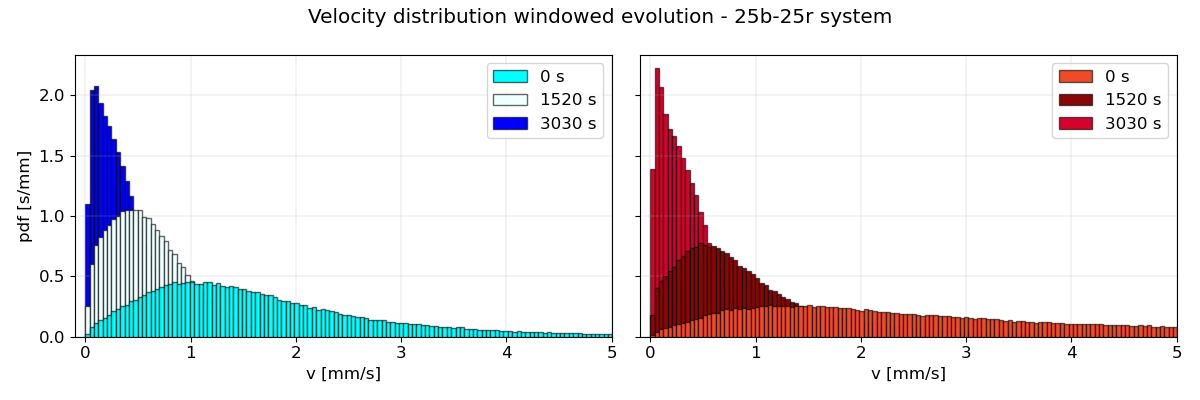

In [38]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (12, 4), sharey = True, sharex=True)
ax.hist(v_blue_wind[0], bins = bin_borders, **default_kwargs_blue, label = f"{int(startFrames[0]/fps)} s", zorder = 3)
ax.hist(v_blue_wind[int(nSteps/2)], bins = bin_borders,  **default_kwargs_blue2, label = f"{int(startFrames[int(nSteps/2)]/fps)} s", zorder = 2)
ax.hist(v_blue_wind[-1], bins = bin_borders,  **default_kwargs_blue3, label = f"{int(startFrames[-1]/fps)} s", zorder = 1)
ax1.hist(v_red_wind[0], bins = bin_borders, **default_kwargs_red, label = f"{int(startFrames[0]/fps)} s", zorder = 3)
ax1.hist(v_red_wind[int(nSteps/2)], bins = bin_borders, **default_kwargs_red2, label = f"{int(startFrames[int(nSteps/2)]/fps)} s", zorder = 2)
ax1.hist(v_red_wind[-1], bins = bin_borders, **default_kwargs_red3, label = f"{int(startFrames[-1]/fps)} s", zorder = 1)
ax.set(xlabel = f"v [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5))
ax.legend()
ax.grid(linewidth = 0.2)
ax1.set(xlabel = f"v [{speed_units}]", xlim = (-.1, 5))
ax1.legend()
ax1.grid(linewidth = 0.2)
plt.suptitle(f"Velocity distribution windowed evolution - {system_name}")
plt.tight_layout()
plt.savefig(f"./{pdf_res_path}/speed_distribution/speed_distribution_wind_evol.pdf", bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
ax.plot(startFrames/fps, v_blue_wind_mean, 'b-',label = 'Blue droplets')
ax.plot(startFrames/fps, v_red_wind_mean, 'r-', label = 'Red droplets')
ax.grid(linewidth = 0.2)
ax.set(xlabel = 'Window time [s]', ylabel = f"v [{speed_units}]", title=f"Windowed mean speed - {system_name}")
ax.legend()
if save_verb:
    plt.savefig(f"./{res_path}/speed_distribution/speed_windowed_mean.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/speed_windowed_mean.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
if plot_verb:   
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    ax.plot(startFrames/fps, r2_blue_wind, 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, r2_red_wind, 'r', label = "Red droplets")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.set(xlabel = "Window time [s]", ylabel = r"$R^2$", title = r"$R^2$")

    ax1.errorbar(startFrames/fps, blue_fit_wind[:, 0], yerr = blue_fit_wind[:, 1], fmt = 'b', label = "Blue droplets")
    ax1.errorbar(startFrames/fps, red_fit_wind[:, 0], yerr = red_fit_wind[:, 1], fmt = 'r', label = "Red droplets")
    ax1.set(ylabel = r"$\sigma \; [mm/s]$", xlabel = "Window time [s]", title = r"$\sigma$")
    ax1.legend()
    ax1.grid(linewidth = 0.2)
    plt.suptitle(f"Windowed velocity distribution with 2D Maxwell Boltzmann fit - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/speed_distribution_windowed.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/speed_distribution_windowed.pdf", bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(startFrames/fps, r2_blue_wind, 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, r2_red_wind, 'r', label = "Red droplets")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.set(xlabel = "Window time [s]", ylabel = r"$R^2$", title = f"R² of the fit of the velocity distribution - {system_name}")
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/r2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/r2.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    # Sigma of velocity distribution plot
    fig, ax = plt.subplots(1, 1, figsize = (10, 4), sharex=True)
    ax.errorbar(startFrames/fps, blue_fit_wind[:, 0], yerr = blue_fit_wind[:, 1], fmt = 'b', label = "Blue droplets")
    ax.errorbar(startFrames/fps, red_fit_wind[:, 0], yerr = red_fit_wind[:, 1], fmt = 'r', label = "Red droplets")
    ax.set(ylabel = r"$\sigma \; [mm/s]$", xlabel = "Window time [s]", title = f"Sigma of MB distribution - {system_name}")
    ax.legend()
    ax.grid(linewidth = 0.2)
    if save_verb: 
        plt.savefig(f'./{res_path}/speed_distribution/sigma_MB.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/speed_distribution/sigma_MB.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    if animated_plot_verb:
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True

        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True


        def prepare_animation(bar_container, bar_container2):
            def animate(frame):
                # update titles
                title.set_text(f"Velocity Distribution at window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")

                # update histogram 1
                n, _ = np.histogram(v_blue_wind[frame], bin_borders, density = True)
                for count, rect in zip(n, bar_container.patches):
                    rect.set_height(count)
                
                line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind[frame, 0]))

                # update histogram 2
                n2, _ = np.histogram(v_red_wind[frame], bin_borders, density = True)
                for count2, rect2 in zip(n2, bar_container2.patches):
                    rect2.set_height(count2)
                    
                line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind[frame, 0]))

                return bar_container.patches, bar_container2.patches
            return animate

        _, _, bar_container = ax.hist(v_blue_wind[0], bin_borders, **default_kwargs_blue, label="Blue droplets")
        title = ax.set_title(f"{system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds  - {system_name}")
        line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[0, 0]), label = 'MB fit')
        ax.set(xlabel = f"v [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 3))
        ax.grid(linewidth = 0.2)
        ax.legend()

        _, _, bar_container2 = ax1.hist(v_red_wind[0], bin_borders,  **default_kwargs_red, label="Red droplets")
        #title2 = ax1.set_title(f"Red droplets velocity pdf {startFrames[0]/fps} - {endFrames[0]/fps} seconds")
        line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind[0, 0]), label = 'MB fit')
        ax1.set(xlabel = f"v [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 3))
        ax1.legend()
        ax1.grid(linewidth = 0.2)

        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
        if save_verb: ani.save(f'./{res_path}/speed_distribution/speed_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb: 
            plt.show()
        else:
            plt.close()

## Generalized 2D Maxwell-Boltzmann distribution fit 

$$ \huge p(v) = A* v e^{-\frac{v^\beta}{2\sigma^\beta}} $$

In [ ]:
print(f"Speed Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
print("\n Global speed distribution analysis")
blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories, 1, fps)

# multiply by pxDimension to get the speed in mm/s
v_blue = ys.speed_ensemble(blueTrajs, step = 1)*pxDimension
v_red = ys.speed_ensemble(redTrajs, step = 1)*pxDimension
sigma_blue_g, sigma_blue_std_g = fit_hist(v_blue, bin_borders, MB_2D_generalized, [1., 2., 1.])
sigma_red_g, sigma_red_std_g = fit_hist(v_red, bin_borders, MB_2D_generalized, [1., 2., 1.])

y = np.histogram(v_blue, bins = bin_borders, density = True)[0]
y_fit = MB_2D_generalized(bin_centers, *sigma_blue_g)
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2_blue_g = 1 - (ss_res / ss_tot)
y = np.histogram(v_red, bins = bin_borders, density = True)[0]
y_fit = MB_2D_generalized(bin_centers, *sigma_red_g)
ss_res = np.sum((y - y_fit) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2_red_g = 1 - (ss_res / ss_tot)

print(f"Blue droplets --> R² = {round(r2_blue_g,3)} -- σ = {round(sigma_blue_g[0], 3)} ± {round(sigma_blue_std_g[0], 3)} mm/s -- b = {round(sigma_blue_g[1], 3)} ± {round(sigma_blue_std_g[1], 3)} -- A = {round(sigma_blue_g[2], 3)} ± {round(sigma_blue_std_g[2], 3)} ")
print(f"Red droplets --> R² = {round(r2_red_g,3)} -- σ = {round(sigma_red_g[0], 4)} ± {round(sigma_red_std_g[0], 4)} mm/s -- b = {round(sigma_red_g[1], 3)} ± {round(sigma_red_std_g[1], 3)} -- A = {round(sigma_red_g[2], 3)} ± {round(sigma_red_std_g[2], 3)}")

if plot_verb:
    fig, (ax, ax1) = plt.subplots(1, 2, figsize = (12, 4))
    ax.hist(v_blue, bins = bin_borders, **default_kwargs_blue, label = "Blue droplets")
    ax.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit, *sigma_blue_g), 'k-', label = f"$ σ= {sigma_blue_g[0]:.3f} \pm {sigma_blue_std_g[0]:.3f}$")
    ax.set(xlabel = f"v [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 1.5))
    ax.legend()
    ax.grid(linewidth = 0.2)

    ax1.hist(v_red, bins = bin_borders, **default_kwargs_red, label = "Red droplets")
    ax1.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit, *sigma_red_g), 'k-', label = f"$ σ = {sigma_red_g[0]:.3f} \pm {sigma_red_std_g[0]:.3f}$")
    ax1.set(xlabel = f"v [{speed_units}]", xlim = (-.1, 5), ylim = (0, 1.5))
    ax1.legend()
    ax1.grid(linewidth = 0.2)
    plt.suptitle(f"Velocity distribution - Generalized MB fit - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/speed_distribution_generalized.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/speed_distribution_generalized.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

In [ ]:
print("\n Windowed speed distribution Analysis")
v_blue_wind, v_red_wind = speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories)
v_blue_wind = np.array(v_blue_wind)*pxDimension
v_red_wind = np.array(v_red_wind)*pxDimension

blue_fit_wind_g = np.zeros((nSteps, 3))
blue_fit_wind_g_std = np.zeros((nSteps, 3))

red_fit_wind_g = np.zeros((nSteps, 3))
red_fit_wind_g_std = np.zeros((nSteps, 3))
for step in range(nSteps):
    blue_fit_wind_g[step], blue_fit_wind_g_std[step] = fit_hist(v_blue_wind[step], bin_borders, MB_2D_generalized, [1., 2., 1.])
    red_fit_wind_g[step], red_fit_wind_g_std[step] = fit_hist(v_red_wind[step], bin_borders, MB_2D_generalized, [1., 2., 1.])


# compute R2 for the fit of the speed distribution at each window
r2_blue_g_wind = np.zeros(nSteps)
r2_red_g_wind = np.zeros(nSteps)

for step in range(nSteps):
    y = np.histogram(v_blue_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D_generalized(bin_centers, *blue_fit_wind_g[step])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_blue_g_wind[step] = 1 - (ss_res / ss_tot)
    y = np.histogram(v_red_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D_generalized(bin_centers,  *red_fit_wind_g[step])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_red_g_wind[step] = 1 - (ss_res / ss_tot)

In [ ]:
if plot_verb:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(startFrames/fps, r2_blue_g_wind, 'b', label = "Generalized fit")
    ax.plot(startFrames/fps, r2_blue_wind, 'b--', label = "Maxwell-Boltzmann fit")
    ax.plot(startFrames/fps, r2_red_g_wind, 'r', label = "Generalized fit")
    ax.plot(startFrames/fps, r2_red_wind, 'r--', label = "Maxwell-Boltzmann fit")
    ax.set(ylabel = "R2", xlabel = "Window time [s]", title = f"R2 confront with MB Generalized fit - {system_name}")
    ax.grid(linewidth = 0.2)
    ax.legend()
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/r2_generalized_MB.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/r2_generalized_MB.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))
    ax.plot(startFrames/fps, blue_fit_wind_g[:, 0], 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, red_fit_wind_g[:, 0], 'r', label = "Red droplets")
    ax.set(xlabel = "Window time [s]", ylabel = r"$\sigma$")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax1.plot(startFrames/fps, blue_fit_wind_g[:, 1], 'b', label = "Blue droplets")
    ax1.plot(startFrames/fps, red_fit_wind_g[:, 1], 'r', label = "Red droplets")
    ax1.set(xlabel = "Window time [s]", ylabel = r"$\beta$")
    ax1.grid(linewidth = 0.2)
    ax2.plot(startFrames/fps, blue_fit_wind_g[:, 2], 'b', label = "Blue droplets")
    ax2.plot(startFrames/fps, red_fit_wind_g[:, 2], 'r', label = "Red droplets")
    ax2.grid(linewidth = 0.2)
    ax2.set(xlabel = "Window time [s]", ylabel = r"$A$")
    plt.suptitle(f"Generalized MB fit parameters evolution - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/fit_results_generalizedMB.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/fit_results_generalizedMB.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
    
    if animated_plot_verb:
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True

        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True


        def prepare_animation(bar_container, bar_container2):
            def animate(frame):
                # update titles
                title.set_text(f"{system_name} - window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")

                # update histogram 1
                n, _ = np.histogram(v_blue_wind[frame], bin_borders, density = True)
                for count, rect in zip(n, bar_container.patches):
                    rect.set_height(count)
                
                line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind[frame, 0]))

                line1.set_ydata(MB_2D_generalized(x_interval_for_fit, *blue_fit_wind_g[frame]))

                # update histogram 2
                n2, _ = np.histogram(v_red_wind[frame], bin_borders, density = True)
                for count2, rect2 in zip(n2, bar_container2.patches):
                    rect2.set_height(count2)
                    
                line2.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind[frame, 0]))

                line3.set_ydata(MB_2D_generalized(x_interval_for_fit,  *red_fit_wind_g[frame]))
                

                return bar_container.patches, bar_container2.patches
            return animate

        _, _, bar_container = ax.hist(v_blue_wind[0], bin_borders, **default_kwargs_blue, label="Blue droplets")
        title = ax.set_title(f"{system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds  - {system_name}")
        line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[0, 0]), label='fit')
        line1, = ax.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit,  *blue_fit_wind_g[0]), label='Generalized fit')
        ax.set(xlabel = f"v [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 3))
        ax.grid(linewidth = 0.2)
        ax.legend()

        _, _, bar_container2 = ax1.hist(v_red_wind[0], bin_borders,  **default_kwargs_red, label="Red droplets")
        line2, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind[0, 0]), label='fit')
        line3, = ax1.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit,  *red_fit_wind_g[0]), label='Generalized fit')
        ax1.set(xlabel = f"v [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 3))
        ax1.grid(linewidth = 0.2)
        ax1.legend()

        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
        if save_verb: ani.save(f'./{res_path}/speed_distribution/speed_wind_confront_generalized_MB.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb: 
            plt.show()
        else:
            plt.close()

# TURNING ANGLES DISTRIBUTIONS

In [5]:
bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/50)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
x_interval_for_fit_turn = np.linspace(bin_borders_turn[0], bin_borders_turn[-1], 10000)

## Gaussian 
$$ \huge p(x) = \frac{1}{\sigma\sqrt{2\pi} } e^{ -\frac{(x-\mu)^2}{2\sigma^2} }$$

In [6]:
print(f"Turning Angles Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
print("\n Global turning angles analysis")
if video_selection == "25b25r":
    blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories, 3, fps)
else:
    blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories, 1, fps)

theta_blue = ys.turning_angles_ensemble(blueTrajs, centered = True)
theta_red  = ys.turning_angles_ensemble(redTrajs, centered = True)
# normal distribution fit
sigma_blue, sigma_blue_std = fit_hist(theta_blue, bin_borders_turn, normal_distr, [1., 0.])
sigma_red, sigma_red_std = fit_hist(theta_red, bin_borders_turn, normal_distr, [1., 0.])

# compute r^2
y = np.histogram(theta_blue, bins = bin_borders_turn, density = True)[0]
y_fit = normal_distr(bin_centers_turn, *sigma_blue)
r2_blue = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))
y = np.histogram(theta_red, bins = bin_borders_turn, density = True)[0]
y_fit = normal_distr(bin_centers_turn, *sigma_red)
r2_red = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))
print(f"Blue droplets σ = {round(sigma_blue[0],3)} ± {round(sigma_blue_std[0],3)}, μ = {round(sigma_blue[1],3)} ± {round(sigma_blue_std[1],3)}, r2 = {round(r2_blue, 3)}")
print(f"Red droplets σ = {round(sigma_red[0],3)} ± {round(sigma_red_std[0],3)}, μ = {round(sigma_red[1],3)} ± {round(sigma_red_std[1],3)}, r2 = {round(r2_red, 3)}")

if plot_verb:
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    ax.hist(theta_blue, bin_borders_turn, **default_kwargs_blue, label="Blue droplets")
    ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *sigma_blue), 'k-',
                    label = f"$σ = {sigma_blue[0]:.2f} \pm {sigma_blue_std[0]:.2f}$")
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax.set(xlabel="pdf", ylabel= r"$\theta$ [rad]")
    ax.legend()
    ax.set_ylim(0, 3)
    ax.grid(linewidth = 0.2)
    ax1.hist(theta_red, bin_borders_turn, **default_kwargs_red, label="Red droplets")
    ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *sigma_red), 'k-',
                    label = f"$σ = {sigma_red[0]:.2f} \pm {sigma_red_std[0]:.2f}$")
    ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax1.set(xlabel="pdf")
    ax1.legend()
    ax1.set_ylim(0, 3)
    ax1.grid(linewidth = 0.2)
    plt.suptitle(f"Turning angles pdf  - Gaussian fit - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/turning_angles/turn_ang_gaussian.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/turn_ang_gaussian.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

Turning Angles Analysis: show_verb = False, animated_plot_verb = False

 Global turning angles analysis
Blue droplets σ = 0.351 ± 0.008, μ = -0.0 ± 0.01, r2 = 0.943
Red droplets σ = 0.286 ± 0.008, μ = -0.0 ± 0.01, r2 = 0.905


In [7]:
print("\n Windowed turning angles analysis")
if video_selection == "25b25r":
    theta_blue_wind, theta_red_wind = turning_angles_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, 3, fps)
else:
    theta_blue_wind, theta_red_wind = turning_angles_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, 1, fps)

blue_fit_wind_turn = np.ones((nSteps, 2, 2))
red_fit_wind_turn = np.ones((nSteps, 2, 2))
r2_blue_gaussian = np.zeros(nSteps)
r2_red_gaussian = np.zeros(nSteps)
for k in range(nSteps):
    blue_fit_wind_turn[k, 0], blue_fit_wind_turn[k, 1] = fit_hist(theta_blue_wind[k], bin_borders_turn, normal_distr, [2., 0.])
    red_fit_wind_turn[k, 0], red_fit_wind_turn[k, 1] = fit_hist(theta_red_wind[k], bin_borders_turn, normal_distr, [2., 0.])
    y = np.histogram(theta_blue_wind[k], bins = bin_borders_turn, density = True)[0]
    y_fit = normal_distr(bin_centers_turn, *blue_fit_wind_turn[k, 0])
    r2_blue_gaussian[k] = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))
    y = np.histogram(theta_red_wind[k], bins = bin_borders_turn, density = True)[0]
    y_fit = normal_distr(bin_centers_turn, *red_fit_wind_turn[k, 0])
    r2_red_gaussian[k] = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))



 Windowed turning angles analysis


100%|██████████| 304/304 [01:25<00:00,  3.55it/s]


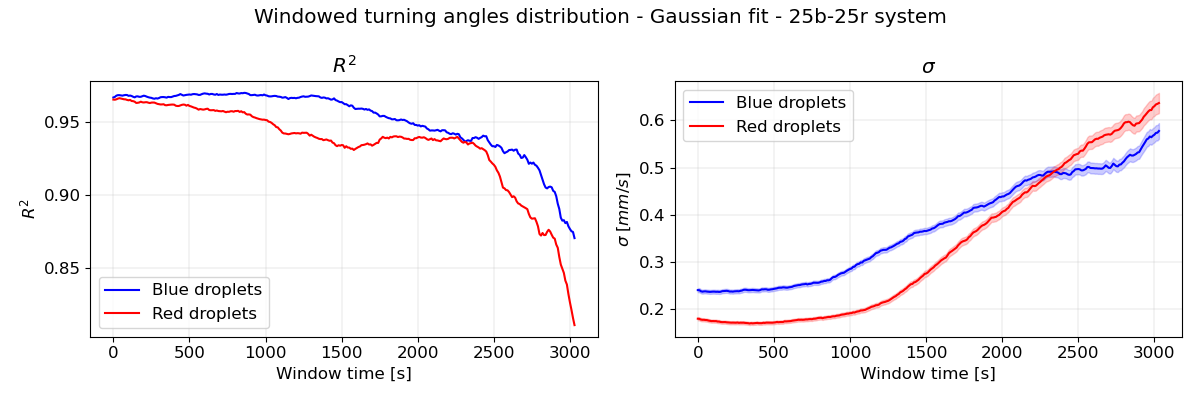

In [8]:
if plot_verb: 
    fig, (ax, ax1) = plt.subplots(1, 2, figsize = (12, 4))
    ax.plot(startFrames/fps, r2_blue_gaussian, 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, r2_red_gaussian, 'r', label = "Red droplets")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.grid(linewidth = 0.2)
    ax.set(xlabel = "Window time [s]", ylabel = r"$R^2$", title = r"$R^2$")

    ax1.plot(startFrames/fps, blue_fit_wind_turn[:, 0, 0], 'b', label="Blue droplets")
    ax1.fill_between(startFrames/fps, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                    blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color = 'b', alpha = 0.2)
    ax1.set(ylabel = r"$\sigma \; [mm/s]$", xlabel = "Window time [s]", title = r"$\sigma$")

    ax1.plot(startFrames/fps, red_fit_wind_turn[:, 0, 0], 'r', label = "Red droplets")
    ax1.fill_between(startFrames/fps, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                        red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
    ax1.legend()
    ax1.grid(linewidth = 0.2)
    plt.suptitle(f"Windowed turning angles distribution - Gaussian fit - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/turning_angles/turn_ang_gaussian_windowed.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/turn_ang_gaussian_windowed.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(startFrames/fps, r2_blue_gaussian, 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, r2_red_gaussian, 'r', label = "Red droplets")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.grid(linewidth = 0.2)
    ax.set(xlabel = "Window time [s]", ylabel = r"$R^2$", title = f"R² of the Gaussian fit of the turning angles distribution - {system_name}")
    if save_verb: 
        plt.savefig(f"./{res_path}/turning_angles/r2_gaussian.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/r2_gaussian.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
    ax.plot(startFrames/fps, blue_fit_wind_turn[:, 0, 0], 'b', label="Blue droplets")
    ax.fill_between(startFrames/fps, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                    blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color = 'b', alpha = 0.2)
    ax.set(ylabel = r"$\sigma \; [mm/s]$", xlabel = "Window time [s]", title = f"Sigma of gaussian distribution - {system_name}")

    ax.plot(startFrames/fps, red_fit_wind_turn[:, 0, 0], 'r', label = "Red droplets")
    ax.fill_between(startFrames/fps, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                        red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
    ax.legend()
    ax.grid(linewidth = 0.2)
    if save_verb: 
        plt.savefig(f'./{res_path}/turning_angles/fit_results_gaussian.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/turning_angles/fit_results_gaussian.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    ##############################################################################################################
    #                                              Animated Plots                                                #
    ##############################################################################################################
    if animated_plot_verb:
        
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def prepare_animation(bar_container, bar_container2):
            def animate(frame):
                title.set_text(f"Turning angles pdf - {system_name} - window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")
                n, _ = np.histogram(theta_blue_wind[frame], bin_borders_turn, density = True)
                for count, rect in zip(n, bar_container.patches):
                    rect.set_height(count)
                line.set_ydata(normal_distr(x_interval_for_fit_turn, *blue_fit_wind_turn[frame, 0]))
                n2, _ = np.histogram(theta_red_wind[frame], bin_borders_turn, density = True)
                for count2, rect2 in zip(n2, bar_container2.patches):
                    rect2.set_height(count2)
                line1.set_ydata(normal_distr(x_interval_for_fit_turn, *red_fit_wind_turn[frame, 0]))
                return bar_container.patches, bar_container2.patches
            return animate
        _, _, bar_container = ax.hist(theta_red_wind[0], bin_borders_turn, **default_kwargs_blue, label="Blue droplets")
        line, = ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *blue_fit_wind_turn[0, 0]), label='fit')
        title = ax.set_title(f"Turning angles pdf - {system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds - {system_name}")
        ax.set(ylabel = "pdf", ylim = (0, 4))
        ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
        ax.grid(linewidth = 0.2)

        _, _, bar_container2 = ax1.hist(theta_red_wind[0], bin_borders_turn,  **default_kwargs_red, label="Red droplets")
        line1, = ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *red_fit_wind_turn[0, 0]), label='fit')
        ax1.set(ylabel = "pdf", ylim = (0, 4))
        ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
        ax1.grid(linewidth = 0.2)

        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
        if save_verb:
            ani.save(f'./{res_path}/turning_angles/turn_ang_wind_gaussian.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

## Lorentzian Fit 
$$ \huge p(x) = \frac{1}{\pi}\frac{\gamma}{(x-x_0) + \gamma^2} $$

In [9]:
print(f"Turning Angles Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
print("\n Global turning angles analysis")
if video_selection == "25b25r":
    blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories, 3, fps)
else:
    blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories, 1, fps)

theta_blue = ys.turning_angles_ensemble(blueTrajs, centered = True)
theta_red  = ys.turning_angles_ensemble(redTrajs, centered = True)
# normal distribution fit
gamma_blue, gamma_blue_std = fit_hist(theta_blue, bin_borders_turn, lorentzian_distr, [1., 0.])
gamma_red, gamma_red_std = fit_hist(theta_red, bin_borders_turn, lorentzian_distr, [1., 0.])
# compute r^2
y = np.histogram(theta_blue, bins = bin_borders_turn, density = True)[0]
y_fit = lorentzian_distr(bin_centers_turn, *gamma_blue)
r2_blue = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))
y = np.histogram(theta_red, bins = bin_borders_turn, density = True)[0]
y_fit = lorentzian_distr(bin_centers_turn, *gamma_red)
r2_red = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))

print(f"Blue droplets γ = {round(gamma_blue[0],3)} ± {round(gamma_blue_std[0],3)}, μ = {round(gamma_blue[1],3)} ± {round(gamma_blue_std[1],3)}, r2 = {round(r2_blue, 3)}")
print(f"Red droplets γ = {round(gamma_red[0],3)} ± {round(gamma_red_std[0],3)}, μ = {round(gamma_red[1],3)} ± {round(gamma_red_std[1],3)}, r2 = {round(r2_red, 3)}")

if plot_verb:
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    ax.hist(theta_blue, bin_borders_turn, **default_kwargs_blue, label="Blue droplets")
    ax.plot(x_interval_for_fit_turn, lorentzian_distr(x_interval_for_fit_turn, *gamma_blue), 'k-',
                    label = f"$γ = {gamma_blue[0]:.2f} \pm {gamma_blue_std[0]:.2f}$")
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax.set(xlabel="pdf", ylabel= r"$\theta$ [rad]")
    ax.legend()
    ax.set_ylim(0, 3)
    ax.grid(linewidth = 0.2)

    ax1.hist(theta_red, bin_borders_turn, **default_kwargs_red, label="Red droplets")
    ax1.plot(x_interval_for_fit_turn, lorentzian_distr(x_interval_for_fit_turn, *gamma_red), 'k-',
                    label = f"$γ = {gamma_red[0]:.2f} \pm {gamma_red_std[0]:.2f}$")
    ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax1.set(xlabel="pdf")
    ax1.legend()
    ax1.set_ylim(0, 3)
    ax1.grid(linewidth = 0.2)
    plt.suptitle(f"Turning angles pdf - Lorentzian fit - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/turning_angles/turn_ang_lorentzian.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/turn_ang_lorentzian.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

Turning Angles Analysis: show_verb = False, animated_plot_verb = False

 Global turning angles analysis
Blue droplets γ = 0.255 ± 0.002, μ = -0.0 ± 0.002, r2 = 0.996
Red droplets γ = 0.201 ± 0.001, μ = -0.0 ± 0.001, r2 = 0.998


In [10]:
print("\n Windowed turning angles analysis")
if video_selection == "25b25r":
    theta_blue_wind, theta_red_wind = turning_angles_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, 3, fps)
else:
    theta_blue_wind, theta_red_wind = turning_angles_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, 1, fps)

blue_fit_wind_turn = np.ones((nSteps, 2, 2))
red_fit_wind_turn = np.ones((nSteps, 2, 2))
r2_blue_lorentzian = np.zeros(nSteps)
r2_red_lorentzian = np.zeros(nSteps)
for k in range(nSteps):
    blue_fit_wind_turn[k, 0], blue_fit_wind_turn[k, 1] = fit_hist(theta_blue_wind[k], bin_borders_turn, lorentzian_distr, [1., 0.])
    red_fit_wind_turn[k, 0], red_fit_wind_turn[k, 1] = fit_hist(theta_red_wind[k], bin_borders_turn, lorentzian_distr, [1., 0.])
    y = np.histogram(theta_blue_wind[k], bins = bin_borders_turn, density = True)[0]
    y_fit = lorentzian_distr(bin_centers_turn, *blue_fit_wind_turn[k, 0])
    r2_blue_lorentzian[k] = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))
    y = np.histogram(theta_red_wind[k], bins = bin_borders_turn, density = True)[0]
    y_fit = lorentzian_distr(bin_centers_turn, *red_fit_wind_turn[k, 0])
    r2_red_lorentzian[k] = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))


 Windowed turning angles analysis


In [14]:
if plot_verb: 
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(startFrames/fps, r2_blue_lorentzian, 'b', label = "Lorentzian Fit")
    ax.plot(startFrames/fps, r2_red_lorentzian, 'r', label = "Lorentzian fit")
    ax.plot(startFrames/fps, r2_blue_gaussian, 'b--', label = "Gaussian Fit")
    ax.plot(startFrames/fps, r2_red_gaussian, 'r--', label = "Gaussian Fit")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.set(xlabel = "Window time [s]", ylabel = r"$R^2$", title = f"R² confront fit of the turning angles distribution - {system_name}")
    if save_verb: 
        plt.savefig(f"./{res_path}/turning_angles/r2_confront.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/r2_confront.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
        
    fig, (ax, ax1) = plt.subplots(1, 2, figsize = (12, 4))
    ax.plot(startFrames/fps, r2_blue_lorentzian, 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, r2_red_lorentzian, 'r', label = "Red droplets")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.grid(linewidth = 0.2)
    ax.set(xlabel = "Window time [s]", ylabel = r"$R^2$", title = r"$R^2$")

    ax1.plot(startFrames/fps, blue_fit_wind_turn[:, 0, 0], 'b', label="Blue droplets")
    ax1.fill_between(startFrames/fps, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                    blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color = 'b', alpha = 0.2)
    ax1.set(ylabel = r"$\sigma \; [mm/s]$", xlabel = "Window time [s]", title = r"$\gamma$")

    ax1.plot(startFrames/fps, red_fit_wind_turn[:, 0, 0], 'r', label = "Red droplets")
    ax1.fill_between(startFrames/fps, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                        red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
    ax1.legend()
    ax1.grid(linewidth = 0.2)
    plt.suptitle(f"Windowed turning angles distribution - Lorentzian fit - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/turning_angles/turn_ang_lorentzian_windowed.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/turn_ang_lorentzian_windowed.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(startFrames/fps, r2_blue_lorentzian, 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, r2_red_lorentzian, 'r', label = "Red droplets")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.set(xlabel = "Window time [s]", ylabel = r"$R^2$", title = f"R² of the Lorentzian fit of the turning angles distribution - {system_name}")
    if save_verb: 
        plt.savefig(f"./{res_path}/turning_angles/r2_lorentzian.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/r2_lorentzian.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
    ax.plot(startFrames/fps, blue_fit_wind_turn[:, 0, 0], 'b', label="Blue droplets")
    ax.fill_between(startFrames/fps, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                    blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color = 'b', alpha = 0.2)
    ax.set(ylabel = r"$\gamma \; [mm/s]$", xlabel = "Window time [s]", title = f"Gamma of Lorentzian distribution - {system_name}")

    ax.plot(startFrames/fps, red_fit_wind_turn[:, 0, 0], 'r', label = "Red droplets")
    ax.fill_between(startFrames/fps, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                        red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
    ax.legend()
    ax.grid(linewidth = 0.2)
    if save_verb: 
        plt.savefig(f'./{res_path}/turning_angles/fit_results_lorentzian.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/turning_angles/fit_results_lorentzian.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    ##############################################################################################################
    #                                              Animated Plots                                                #
    ##############################################################################################################
    if animated_plot_verb:
        
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def prepare_animation(bar_container, bar_container2):
            def animate(frame):
                title.set_text(f"Turning angles pdf - {system_name} - window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds")
                n, _ = np.histogram(theta_blue_wind[frame], bin_borders_turn, density = True)
                for count, rect in zip(n, bar_container.patches):
                    rect.set_height(count)
                line.set_ydata(lorentzian_distr(x_interval_for_fit_turn, *blue_fit_wind_turn[frame, 0]))
                n2, _ = np.histogram(theta_red_wind[frame], bin_borders_turn, density = True)
                for count2, rect2 in zip(n2, bar_container2.patches):
                    rect2.set_height(count2)
                line1.set_ydata(lorentzian_distr(x_interval_for_fit_turn, *red_fit_wind_turn[frame, 0]))
                return bar_container.patches, bar_container2.patches
            return animate
        _, _, bar_container = ax.hist(theta_red_wind[0], bin_borders_turn, **default_kwargs_blue, label="Blue droplets")
        line, = ax.plot(x_interval_for_fit_turn, lorentzian_distr(x_interval_for_fit_turn, *blue_fit_wind_turn[0, 0]), label='fit')
        title = ax.set_title(f"Turning angles pdf - {system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds - {system_name}")
        ax.set(ylabel = "pdf", ylim = (0, 4))
        ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
        ax.grid(linewidth = 0.2)
        _, _, bar_container2 = ax1.hist(theta_red_wind[0], bin_borders_turn,  **default_kwargs_red, label="Red droplets")
        line1, = ax1.plot(x_interval_for_fit_turn, lorentzian_distr(x_interval_for_fit_turn, *red_fit_wind_turn[0, 0]), label='fit')
        ax1.set(ylabel = "pdf", ylim = (0, 4))
        ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
        ax1.grid(linewidth = 0.2)
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
        ani.save(f'./{res_path}/turning_angles/turn_ang_wind_lorentzian.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# VELOCITY AUTOCORRELATION

In [ ]:
print(f"Velocity Autocorrelation Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")
print("Global Velocity Autocovariance Function")

blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories, 1, fps)
vacf_b, vacf_std_b = ys.vacf(blueTrajs, time_avg=True, lag = maxLagtime)
vacf_r, vacf_std_r = ys.vacf(redTrajs, time_avg=True, lag = maxLagtime)

In [ ]:
if plot_verb:
    #Global Velocity Autocovariance
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    ax.errorbar(np.arange(0, maxLagtime/fps, 1/fps), vacf_b, fmt='o', markersize = 1, color = "blue", label = 'Blue droplets')
    ax.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b + vacf_std_b, vacf_b - vacf_std_b, alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.set(xlim = (-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(mm/s)^2$]')
    ax1.errorbar(np.arange(0, maxLagtime/fps, 1/fps), vacf_r, fmt='o', markersize = 1, color = "red", label = 'Red droplets')
    ax1.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r + vacf_std_r, vacf_r - vacf_std_r, alpha=1, edgecolor='#FF0000', facecolor='#FFCCCB')
    ax1.set(xlim = (-1, 10), xlabel = 'Lag time [s]')
    ax1.grid(linewidth = 0.2)
    ax1.legend()
    plt.suptitle(f"Velocity autocorrelation function - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/velocity_autocovariance/vacf.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/velocity_autocovariance/vacf.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

In [ ]:
print("Windowed analysis")
if 0:
    vacf_b_wind, vacf_b_std_wind, vacf_r_wind, vacf_r_std_wind = vacf_windowed(trajectories)
else:
    vacf_b_wind     = pd.read_parquet(f"./{analysis_data_path}/vacf/vacf_b_wind.parquet")
    vacf_b_std_wind = pd.read_parquet(f"./{analysis_data_path}/vacf/vacf_b_std_wind.parquet")
    vacf_r_wind     = pd.read_parquet(f"./{analysis_data_path}/vacf/vacf_r_wind.parquet")
    vacf_r_std_wind = pd.read_parquet(f"./{analysis_data_path}/vacf/vacf_r_std_wind.parquet")

In [ ]:
vacf_b_wind

In [ ]:
if plot_verb:
    # Velocity Variance
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(startFrames/fps, vacf_b_wind["0"], 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, vacf_r_wind["0"], 'r', label = "Red droplets")
    ax.set(title = f"Time evolution of velocity variance - {system_name}", ylabel = "$\sigma$", xlabel = "Window Time [s]")
    ax.grid(linewidth = 0.2)
    ax.legend()
    if save_verb: 
        plt.savefig(f"./{res_path}/velocity_autocovariance/vacf_wind_0.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/velocity_autocovariance/vacf_wind_0.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else: 
        plt.close()

    # Animated Plots
    if animated_plot_verb:
        fig = plt.figure(figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            line.set_ydata(vacf_b_wind.iloc[step]/vacf_b_wind.iloc[step]["0"])
            title.set_text(f"Velocity autocorrelation - {system_name} - window [{startFrames[step]/fps} - {endFrames[step]/fps}] s")
            line1.set_ydata(vacf_r_wind.iloc[step]/vacf_r_wind.iloc[step]["0"])
            return line, line1,
        ax = fig.add_subplot(211)
        title = ax.set_title(f"Velocity autocorrelation - {system_name} - window [{startFrames[0]/fps} - {endFrames[0]/fps}] s")
        line, = ax.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind.iloc[0]/vacf_b_wind.iloc[0]["0"], 'b-', label = 'Blue droplets')
        ax.set(ylabel = r'vacf [$(mm/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.1))
        ax.grid(linewidth = 0.2)
        ax.legend()
        ax1 = fig.add_subplot(212)
        line1, = ax1.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind.iloc[0]/vacf_r_wind.iloc[0]["0"], 'r-', label = 'Red droplets')
        ax1.set(ylabel = r'vacf [$(mm/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.1))
        ax1.grid(linewidth = 0.2)
        ax1.legend()
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/velocity_autocovariance/vacf_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

In [ ]:
if 1: 
    vacf_b_wind = np.array(vacf_b_wind)
    vacf_b_std_wind = np.array(vacf_b_std_wind)
    vacf_r_wind = np.array(vacf_r_wind)
    vacf_r_std_wind = np.array(vacf_r_std_wind)
    
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
    ax.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[0, :]/vacf_b_wind[0, 0], 'b', label = "Blue droplets")
    ax.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[0, :]/vacf_b_wind[0, 0] - vacf_b_std_wind[0, :]/vacf_b_wind[0, 0], 
                    vacf_b_wind[0, :]/vacf_b_wind[0, 0] + vacf_b_std_wind[0, :]/vacf_b_wind[0, 0], color = 'b', alpha = 0.2)
    ax.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[0, :]/vacf_r_wind[0, 0], 'r', label = "Red droplets")
    ax.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[0, :]/vacf_r_wind[0, 0] - vacf_r_std_wind[0, :]/vacf_r_wind[0, 0],
                    vacf_r_wind[0, :]/vacf_r_wind[0, 0] + vacf_r_std_wind[0, :]/vacf_r_wind[0, 0], color = 'r', alpha = 0.2)
    ax.set(xlabel = "Lag time [s]", ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[1]/fps} - {endFrames[1]/fps}] s")
    ax1.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0], 'b', label = "Blue droplets")
    ax1.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0] - vacf_b_std_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0],
                    vacf_b_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0] + vacf_b_std_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0], color = 'b', alpha = 0.2)
    ax1.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0], 'r', label = "Red droplets")
    ax1.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0] - vacf_r_std_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0],
                    vacf_r_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0] + vacf_r_std_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0], color = 'r', alpha = 0.2)
    ax1.set(xlabel = "Lag time [s]", title = f"Window [{startFrames[int(nSteps/2)]/fps} - {endFrames[int(nSteps/2)]/fps}] s")
    ax2.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[-1, :]/vacf_b_wind[-1, 0], 'b', label = "Blue droplets")
    ax2.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[-1, :]/vacf_b_wind[-1, 0] - vacf_b_std_wind[-1, :]/vacf_b_wind[-1, 0],
                    vacf_b_wind[-1, :]/vacf_b_wind[-1, 0] + vacf_b_std_wind[-1, :]/vacf_b_wind[-1, 0], color = 'b', alpha = 0.2)
    ax2.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[-1, :]/vacf_r_wind[-1, 0], 'r', label = "Red droplets")
    ax2.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[-1, :]/vacf_r_wind[-1, 0] - vacf_r_std_wind[-1, :]/vacf_r_wind[-1, 0],
                    vacf_r_wind[-1, :]/vacf_r_wind[-1, 0] + vacf_r_std_wind[-1, :]/vacf_r_wind[-1, 0], color = 'r', alpha = 0.2)
    ax2.set(xlabel = "Lag time [s]", title = f"Window [{startFrames[-1]/fps} - {endFrames[-1]/fps}] s")

    ax.legend()
    ax1.legend()
    ax2.legend()
    ax.grid(linewidth = 0.2)
    ax1.grid(linewidth = 0.2)
    ax2.grid(linewidth = 0.2)
    ax.set(xlim=(-1, 20))
    ax1.set(xlim=(-1, 20))
    ax2.set(xlim=(-1, 20))
    plt.suptitle(f"Velocity autocovariance windowed - {system_name}")
    plt.tight_layout()
    if save_verb:
        plt.savefig(f'./{res_path}/velocity_autocovariance/evolution.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/velocity_autocovariance/evolution.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    fig, axs = plt.subplots(2, 3, figsize=(15, 6))
    axs[0,0].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[0, :], 'b', label = "Blue droplets")
    axs[0,0].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[0, :] - vacf_b_std_wind[0, :], 
                    vacf_b_wind[0, :] + vacf_b_std_wind[0, :], color = 'b', alpha = 0.2)
    axs[1,0].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[0, :], 'r', label = "Red droplets")
    axs[1,0].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[0, :] - vacf_r_std_wind[0, :],
                    vacf_r_wind[0, :] + vacf_r_std_wind[0, :], color = 'r', alpha = 0.2)
    axs[0,0].set(ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[1]/fps} - {endFrames[1]/fps}] s")
    axs[1,0].set(xlabel = "Lag time [s]", ylabel = r'VACF [$(mm/s)^2$]')
    axs[0,1].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[int(nSteps/2), :], 'b', label = "Blue droplets")
    axs[0,1].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[int(nSteps/2), :] - vacf_b_std_wind[int(nSteps/2), :],
                    vacf_b_wind[int(nSteps/2), :] + vacf_b_std_wind[int(nSteps/2), :], color = 'b', alpha = 0.2)
    axs[1,1].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[int(nSteps/2), :], 'r', label = "Red droplets")
    axs[1,1].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[int(nSteps/2), :] - vacf_r_std_wind[int(nSteps/2), :],
                    vacf_r_wind[int(nSteps/2), :] + vacf_r_std_wind[int(nSteps/2), :], color = 'r', alpha = 0.2)
    axs[0,1].set(ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[int(nSteps/2)]/fps} - {endFrames[int(nSteps/2)]/fps}] s")
    axs[1,1].set(xlabel = "Lag time [s]")
    axs[0,2].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[-1, :], 'b', label = "Blue droplets")
    axs[0,2].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[-1, :] - vacf_b_std_wind[-1, :],
                    vacf_b_wind[-1, :] + vacf_b_std_wind[-1, :], color = 'b', alpha = 0.2)
    axs[1,2].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[-1, :], 'r', label = "Red droplets")
    axs[1,2].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[-1, :] - vacf_r_std_wind[-1, :],
                    vacf_r_wind[-1, :] + vacf_r_std_wind[-1, :], color = 'r', alpha = 0.2)
    axs[0,2].set(ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[-1]/fps} - {endFrames[-1]/fps}] s")
    axs[1,2].set(xlabel = "Lag time [s]")
    axs[0,0].legend()
    axs[0,1].legend()
    axs[0,2].legend()
    axs[1,0].legend()
    axs[1,1].legend()
    axs[1,2].legend()
    axs[0,0].grid(linewidth = 0.2)
    axs[0,1].grid(linewidth = 0.2)
    axs[0,2].grid(linewidth = 0.2)
    axs[1,0].grid(linewidth = 0.2)
    axs[1,1].grid(linewidth = 0.2)
    axs[1,2].grid(linewidth = 0.2)
    axs[0,0].set(xlim = (-1, 20))
    axs[0,1].set(xlim = (-1, 20))
    axs[0,2].set(xlim = (-1, 20))
    axs[1,0].set(xlim = (-1, 20))
    axs[1,1].set(xlim = (-1, 20))
    axs[1,2].set(xlim = (-1, 20))
    plt.suptitle(f"Velocity autocovariance windowed - {system_name}")

    plt.tight_layout()
    if save_verb:
        plt.savefig(f'./{res_path}/velocity_autocovariance/evolution_v2.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/velocity_autocovariance/evolution_v2.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
        
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
    ax.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[0, :]/vacf_b_wind[0, 0], 'b', label = "Blue droplets")
    ax.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[0, :]/vacf_b_wind[0, 0] - vacf_b_std_wind[0, :]/vacf_b_wind[0, 0], 
                    vacf_b_wind[0, :]/vacf_b_wind[0, 0] + vacf_b_std_wind[0, :]/vacf_b_wind[0, 0], color = 'b', alpha = 0.2)
    ax.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[0, :]/vacf_r_wind[0, 0], 'r', label = "Red droplets")
    ax.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[0, :]/vacf_r_wind[0, 0] - vacf_r_std_wind[0, :]/vacf_r_wind[0, 0],
                    vacf_r_wind[0, :]/vacf_r_wind[0, 0] + vacf_r_std_wind[0, :]/vacf_r_wind[0, 0], color = 'r', alpha = 0.2)
    ax.set(xlabel = "Lag time [s]", ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[1]/fps} - {endFrames[1]/fps}] s")
    ax1.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[135, :]/vacf_b_wind[135, 0], 'b', label = "Blue droplets")
    ax1.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[135, :]/vacf_b_wind[135, 0] - vacf_b_std_wind[135, :]/vacf_b_wind[135, 0],
                    vacf_b_wind[135, :]/vacf_b_wind[135, 0] + vacf_b_std_wind[135, :]/vacf_b_wind[135, 0], color = 'b', alpha = 0.2)
    ax1.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[135, :]/vacf_r_wind[135, 0], 'r', label = "Red droplets")
    ax1.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[135, :]/vacf_r_wind[135, 0] - vacf_r_std_wind[135, :]/vacf_r_wind[135, 0],
                    vacf_r_wind[135, :]/vacf_r_wind[135, 0] + vacf_r_std_wind[135, :]/vacf_r_wind[135, 0], color = 'r', alpha = 0.2)
    ax1.set(xlabel = "Lag time [s]", ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[135]/fps} - {endFrames[135]/fps}] s")
    ax2.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[269, :]/vacf_b_wind[269, 0], 'b', label = "Blue droplets")
    ax2.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[269, :]/vacf_b_wind[269, 0] - vacf_b_std_wind[269, :]/vacf_b_wind[269, 0],
                    vacf_b_wind[269, :]/vacf_b_wind[269, 0] + vacf_b_std_wind[269, :]/vacf_b_wind[269, 0], color = 'b', alpha = 0.2)
    ax2.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[269, :]/vacf_r_wind[269, 0], 'r', label = "Red droplets")
    ax2.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[269, :]/vacf_r_wind[269, 0] - vacf_r_std_wind[269, :]/vacf_r_wind[269, 0],
                    vacf_r_wind[269, :]/vacf_r_wind[269, 0] + vacf_r_std_wind[269, :]/vacf_r_wind[269, 0], color = 'r', alpha = 0.2)
    ax2.set(xlabel = "Lag time [s]", ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[269]/fps} - {endFrames[269]/fps}] s")
    ax.legend()
    ax1.legend()
    ax2.legend()
    ax.grid(linewidth = 0.2)
    ax1.grid(linewidth = 0.2)
    ax2.grid(linewidth = 0.2)
    ax.set(xlim=(-1, 20))
    ax1.set(xlim=(-1, 20))
    ax2.set(xlim=(-1, 20))
    plt.suptitle(f"Velocity autocovariance windowed - {system_name}")
    plt.tight_layout()
    if save_verb:
        plt.savefig(f'./{res_path}/velocity_autocovariance/evolution_n.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/velocity_autocovariance/evolution_n.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
    axs[0,0].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[0, :]/vacf_b_wind[0, 0], 'b', label = "Blue droplets")
    axs[0,0].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[0, :]/vacf_b_wind[0, 0] - vacf_b_std_wind[0, :]/vacf_b_wind[0, 0], 
                    vacf_b_wind[0, :]/vacf_b_wind[0, 0] + vacf_b_std_wind[0, :]/vacf_b_wind[0, 0], color = 'b', alpha = 0.2)
    axs[1,0].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[0, :]/vacf_r_wind[0, 0], 'r', label = "Red droplets")
    axs[1,0].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[0, :]/vacf_r_wind[0, 0] - vacf_r_std_wind[0, :]/vacf_r_wind[0, 0],
                    vacf_r_wind[0, :]/vacf_r_wind[0, 0] + vacf_r_std_wind[0, :]/vacf_r_wind[0, 0], color = 'r', alpha = 0.2)
    axs[0,0].set(ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[1]/fps} - {endFrames[1]/fps}] s")
    axs[1,0].set(xlabel = "Lag time [s]", ylabel = r'VACF [$(mm/s)^2$]')
    axs[0,1].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0], 'b', label = "Blue droplets")
    axs[0,1].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0] - vacf_b_std_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0],
                    vacf_b_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0] + vacf_b_std_wind[int(nSteps/2), :]/vacf_b_wind[int(nSteps/2), 0], color = 'b', alpha = 0.2)
    axs[1,1].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0], 'r', label = "Red droplets")
    axs[1,1].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0] - vacf_r_std_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0],
                    vacf_r_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0] + vacf_r_std_wind[int(nSteps/2), :]/vacf_r_wind[int(nSteps/2), 0], color = 'r', alpha = 0.2)
    axs[0,1].set(ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[int(nSteps/2)]/fps} - {endFrames[int(nSteps/2)]/fps}] s")
    axs[1,1].set(xlabel = "Lag time [s]")
    axs[0,2].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[-1, :]/vacf_b_wind[-1, 0], 'b', label = "Blue droplets")
    axs[0,2].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind[-1, :]/vacf_b_wind[-1, 0] - vacf_b_std_wind[-1, :]/vacf_b_wind[-1, 0],
                    vacf_b_wind[-1, :]/vacf_b_wind[-1, 0] + vacf_b_std_wind[-1, :]/vacf_b_wind[-1, 0], color = 'b', alpha = 0.2)
    axs[1,2].plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[-1, :]/vacf_r_wind[-1, 0], 'r', label = "Red droplets")
    axs[1,2].fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind[-1, :]/vacf_r_wind[-1, 0] - vacf_r_std_wind[-1, :]/vacf_r_wind[-1, 0],
                    vacf_r_wind[-1, :]/vacf_r_wind[-1, 0] + vacf_r_std_wind[-1, :]/vacf_r_wind[-1, 0], color = 'r', alpha = 0.2)
    axs[0,2].set(ylabel = r'VACF [$(mm/s)^2$]', title = f"Window [{startFrames[-1]/fps} - {endFrames[-1]/fps}] s")
    axs[1,2].set(xlabel = "Lag time [s]")
    axs[0,0].legend()
    axs[0,1].legend()
    axs[0,2].legend()
    axs[1,0].legend()
    axs[1,1].legend()
    axs[1,2].legend()
    axs[0,0].grid(linewidth = 0.2)
    axs[0,1].grid(linewidth = 0.2)
    axs[0,2].grid(linewidth = 0.2)
    axs[1,0].grid(linewidth = 0.2)
    axs[1,1].grid(linewidth = 0.2)
    axs[1,2].grid(linewidth = 0.2)
    axs[0,0].set(xlim = (-1, 20))
    axs[0,1].set(xlim = (-1, 20))
    axs[0,2].set(xlim = (-1, 20))
    axs[1,0].set(xlim = (-1, 20))
    axs[1,1].set(xlim = (-1, 20))
    axs[1,2].set(xlim = (-1, 20))
    plt.suptitle(f"Velocity autocovariance windowed - {system_name}")
    plt.tight_layout()
    if save_verb:
        plt.savefig(f'./{res_path}/velocity_autocovariance/evolution_v2_n.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/velocity_autocovariance/evolution_v2_n.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

# RADIAL DISTRIBUTON FUNCTION

In [ ]:
print(f"RDF - {system_name} v2")
run_analysis_verb = False

n_red = len(red_particle_idx)
n_blue = nDrops - n_red
dr = trajectories.r.mean()
# center of petri dish --> to refine
r_c = [(xmax-xmin)+ xmin, (ymax-ymin)+ ymin]
rDisk = (xmax-xmin)/2
rList = np.arange(0, 2*rDisk, 1)
rho_b = n_blue/(np.pi*rDisk**2)
rho_r = n_red/(np.pi*rDisk**2) 
rho = nDrops/(np.pi*rDisk**2)

In [ ]:
if 0:
    rdf = get_rdf(frames, trajectories, red_particle_idx, rList, dr, rho_b, rho_r, n_blue, n_red)
    rdf_b  = rdf[:, 0, :]
    rdf_r  = rdf[:, 1, :]
    rdf_br = rdf[:, 2, :]
    rdf_rb = rdf[:, 3, :]
    rdf_b_df = pd.DataFrame(rdf_b)
    rdf_r_df = pd.DataFrame(rdf_r)
    rdf_br_df = pd.DataFrame(rdf_br)
    rdf_rb_df = pd.DataFrame(rdf_rb)
    # string columns for parquet filetype
    rdf_b_df.columns = [f"{r}" for r in rList]
    rdf_r_df.columns = [f"{r}" for r in rList]
    rdf_br_df.columns = [f"{r}" for r in rList]
    rdf_rb_df.columns = [f"{r}" for r in rList]
    rdf_b_df["frame"] = test_frames
    rdf_r_df["frame"] = test_frames
    rdf_br_df["frame"] = test_frames
    rdf_rb_df["frame"] = test_frames

    rdf_b_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_b.parquet")
    rdf_r_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_r.parquet")
    rdf_br_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_br.parquet")
    rdf_rb_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_rb.parquet")
elif not run_analysis_verb:
    try:
        rdf_b = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_b.parquet"))
        rdf_r = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_r.parquet"))
        rdf_br = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_br.parquet"))
        rdf_rb = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_rb.parquet"))
    except: 
        raise ValueError("rdf data not found. Run analysis verbosely first.")
else: 
    raise ValueError("run_analysis_verb must be True or False")

In [ ]:
if video_selection == "49b1r":
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4),sharex=True, sharey=True)
    ax.plot(rList*pxDimension, rdf_b[0, :], 'b', label = "Blue droplets")
    ax.set(xlabel = "r [mm]", ylabel = r"$g_{bb}(r)$", title=f"RDF at 0 s")
    ax1.plot(rList*pxDimension, rdf_b[15000, :], 'b', label = "Blue droplets")
    ax1.set(xlabel = "r [mm]", ylabel = r"$g_{bb}(r)$", title=f"RDF at 1500 s")
    ax2.plot(rList*pxDimension, rdf_b[-1, :], 'b', label = "Blue droplets")
    ax2.set(xlabel = "r [mm]", ylabel = r"$g_{bb}(r)$", title=f"RDF at 3000 s")
    ax.grid(linewidth = 0.2)
    ax1.grid(linewidth = 0.2)
    ax2.grid(linewidth = 0.2)
    ax.set_ylim(-.1, 5.5)
    plt.suptitle(f"RDF evolution - {system_name}")
    plt.tight_layout()
    if save_verb:
        plt.savefig(f'./{res_path}/radial_distribution_function/rdf_evolution.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/radial_distribution_function/rdf_evolution.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

In [ ]:
for frame in [0, 1500*fps, 3000*fps-1]:
    if video_selection == "49b1r":
        fig, ax = plt.subplots(1, 1, figsize=(12, 4),sharex=True, sharey=True)
        ax.plot(rList*pxDimension, rdf_b[frame, :], 'b', label = "Blue droplets")
        ax.set(xlabel = "r [mm]", ylabel = r"$g_{bb}(r)$")
        ax.legend()
        ax.grid(linewidth = 0.2)
        ax.set_ylim(-.1, 5.5)
        plt.suptitle(f"RDF at {int(frame/fps)} s - {system_name}")
        plt.tight_layout()
        if save_verb:
            plt.savefig(f'./{res_path}/radial_distribution_function/rdf_{frame}.png', bbox_inches='tight')
            plt.savefig(f'./{pdf_res_path}/radial_distribution_function/rdf_{frame}.pdf', bbox_inches='tight')
        if show_verb:
            plt.show()
        else:
            plt.close()
            
    elif video_selection == "25b25r":
        fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4),sharex=True, sharey=True)
        ax.plot(rList*pxDimension, rdf_b[frame, :], 'b', label = "Blue droplets")
        ax1.plot(rList*pxDimension, rdf_r[frame, :], 'r', label = "Red droplets")
        ax2.plot(rList*pxDimension, rdf_br[frame, :], 'g', label = "Blue-Red droplets")
        ax.set(xlabel = "r [mm]", ylabel = r"$g_{bb}(r)$")
        ax1.set(xlabel = "r [mm]", ylabel = r"$g_{rr}(r)$")
        ax2.set(xlabel = "r [mm]", ylabel = r"$g_{br}(r)$")
        ax.legend()
        ax1.legend()
        ax2.legend()
        ax.grid(linewidth = 0.2)
        ax1.grid(linewidth = 0.2)
        ax2.grid(linewidth = 0.2)
        ax.set_ylim(-1, 13)
        plt.suptitle(f"RDF at {int(frame/fps)} s - {system_name}")
        plt.tight_layout()
        if save_verb:
            plt.savefig(f'./{res_path}/radial_distribution_function/rdf_{frame}.png', bbox_inches='tight')
            plt.savefig(f'./{pdf_res_path}/radial_distribution_function/rdf_{frame}.pdf', bbox_inches='tight')
        if show_verb:
            plt.show()
        else:
            plt.close()

In [ ]:
if plot_verb:

    v_min = np.min([rdf_b, rdf_r, rdf_br, rdf_rb])
    v_max = np.max([rdf_b, rdf_r, rdf_br, rdf_rb])

    timearr = np.linspace(0, rdf_b.shape[0], 5)/fps
    timearr = timearr.astype(int)

    g_plot = rdf_b.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 5), yticks = np.linspace(0, g_plot.shape[0], 5))
    ax.set(xticklabels = timearr, yticklabels = (np.linspace(0, 2*rDisk, 5)*pxDimension).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = f"RDF blue-blue heatmap - {system_name}")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_b.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_b.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_r.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 5), yticks = np.linspace(0, g_plot.shape[0], 5))
    ax.set(xticklabels = timearr, yticklabels = (np.linspace(0, 2*rDisk, 5)*pxDimension).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = f"RDF r-r heatmap - {system_name}")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_r.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_r.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_br.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 5), yticks = np.linspace(0, g_plot.shape[0], 5))
    ax.set(xticklabels = timearr, yticklabels = (np.linspace(0, 2*rDisk, 5)*pxDimension).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = f"RDF b-r heatmap - {system_name}")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_br.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_br.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_rb.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 5), yticks = np.linspace(0, g_plot.shape[0], 5))
    ax.set(xticklabels = timearr, yticklabels = (np.linspace(0, 2*rDisk, 5)*pxDimension).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = f"RDF r-b heatmap - {system_name}")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_rb.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_rb.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

    
    if animated_plot_verb:
        # Animated plot for trajs results
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_b[frame])  # update the data.
            title.set_text(f'RDF b-b - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF b-b - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_b.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (mm)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_b.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_r[frame])  # update the data.
            title.set_text(f'RDF r-r - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_r[0])
        title = ax.set_title(f'RDF r-r - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_r.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (mm)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_r.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_br[frame])  # update the data.
            title.set_text(f'RDF b-r - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF b-r - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_br.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (mm)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_br.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_rb[frame])  # update the data.
            title.set_text(f'RDF r-b - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF r-b - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_rb.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (mm)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_rb.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

In [ ]:
if run_analysis_verb:
    print(f"RDF from center - {system_name}")
    rdf_c = get_rdf_center(frames, trajectories, r_c, rList, dr, rho)
    print("Saving rdf_c")
    rdf_c_df = pd.DataFrame(rdf_c)
    # string columns for parquet filetype
    rdf_c_df.columns = [str(i) for i in rList]
    pd.DataFrame(rdf_c_df).to_parquet(f"./{analysis_data_path}/rdf/rdf_center.parquet")
if not run_analysis_verb :
    try: 
        rdf_c = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_center.parquet"))
    except: 
        raise ValueError("rdf data not found. Run analysis verbosely first.")

In [ ]:
if plot_verb:
    timearr = np.linspace(0, rdf_c.shape[0], 10)/fps
    timearr = timearr.astype(int)

    fig, ax = plt.subplots(1, 1, figsize = (10, 4))
    ax.plot(rList, rdf_c.mean(axis=0), label="mean")
    ax.fill_between(rList, rdf_c.mean(axis=0) - rdf_c.std(axis=0), \
                        rdf_c.mean(axis=0) + rdf_c.std(axis=0), alpha=0.3, label="std")
    ax.set(xlabel = "r [mm]", ylabel = "g(r)", title = f"RDF from center - {system_name}")
    ax.legend()
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_center.png", bbox_inches='tight' )
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_center.pdf", bbox_inches='tight' )
    if show_verb: 
        plt.show()
    else:
        plt.close()

    g_plot = rdf_c.T
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    img = ax.imshow(g_plot, vmin = 0, vmax = 10)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = f"rdf from center heatmap - {system_name}")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_center_heatmap.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_center_heatmap.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

    if animated_plot_verb:
        fig, ax = plt.subplots()
        anim_running = True

        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True

        line, = ax.plot(rList, rdf_c[0])
        title = ax.set_title(f'RDF from center - {system_name} 0 s')
        ax.set_ylim(-1, 15)

        def animate(frame):
            line.set_ydata(rdf_c[frame])  # update the data.
            title.set_text(f'RDF from center - {system_name} {int(frame/fps)} s')
            return line, 

        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, nFrames, fps), interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_from_center.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# GRAPH ANALYSIS

In [ ]:
factor = 2.2
cutoff_distance = factor * 2*np.mean(trajectories.r.values.reshape(nFrames, nDrops), axis = 1)/pxDimension

In [ ]:
frame = 1500 * fps
X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
# create dictionary with positions of the agents
dicts = {}
for i in range(len(X)):
    dicts[i] = (X[i, 0], X[i, 1])
# generate random geometric graph with cutoff distance 2.2 times the mean diameter the droplets have at that frame
G = nx.random_geometric_graph(len(dicts), cutoff_distance[frame], pos = dicts, dim = 2)
node_pos = nx.get_node_attributes(G, 'pos')
vor = Voronoi(np.asarray(list(node_pos.values())))

fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax = ax, show_vertices = False, line_colors = 'orange', line_width = 2, line_alpha = 0.6, point_size = 2)
nx.draw(G, pos = node_pos, node_size = 25, node_color = colors, with_labels = False, ax=ax)
ax.set(xlim = (xmin, xmax), ylim = (ymax, ymin), title = f"Random Geometric Graph at {int(frame/fps)} s -- {system_name}", xlabel="x [px]", ylabel="y [px]")
if save_verb:
    plt.savefig(f"./{res_path}/graph/random_geometric_graph.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/graph/random_geometric_graph.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
if 0:
    clust_id_list = []
    for frame in tqdm(frames):
        X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
        dicts = {}
        for j in range(len(X)):
            dicts[j] = (X[j, 0], X[j, 1])
        temp = nx.random_geometric_graph(len(dicts), cutoff_distance[frame], pos=dicts, dim=2)
        clust_id = np.ones(len(X), dtype=int)*-1
        for id, c in enumerate(list(nx.connected_components(temp))):
            clust_id[list(c)] = id
        clust_id_list += list(clust_id)
    clustered_trajs = trajectories.copy()
    clustered_trajs["cluster_id"] = clust_id_list
    clustered_trajs["cluster_color"] = [colors[i] for i in clust_id_list]
    clustered_trajs.to_parquet(f"{analysis_data_path}/clustering/trajs_simple_connections_factor{factor}.parquet")
else:
    clustered_trajs = pd.read_parquet(f"{analysis_data_path}/clustering/trajs_simple_connections_factor{factor}.parquet")

In [ ]:
if 0:
    result = []
    for frame in tqdm(frames):
        df = clustered_trajs.loc[clustered_trajs.frame == frame]
        labels = df.cluster_id.values
        unique_labels, counts = np.unique(labels, return_counts=True)

        for j, cluster_id in enumerate(unique_labels[counts>2]):
            # create subgrah with positions of the agents in the cluster
            df_cluster = df.loc[df.cluster_id == cluster_id]
            X = np.array(df_cluster[['x', 'y']])
            dicts = {}
            for i in range(len(X)):
                dicts[i] = (X[i, 0], X[i, 1])
            temp = nx.random_geometric_graph(len(dicts), cutoff_distance[frame], pos=dicts, dim=2)

            # compute area and eccentricity of the subgraph
            hull = ConvexHull(X)
            area = hull.area
            eccentricity = compute_eccentricity(X)

            # compute degree, degree centrality, betweenness centrality, clustering coefficient, number of cycles,
            # dimension of cycles and first and eigenvalue
            degree = np.mean([val for (_, val) in temp.degree()])
            degree_centrality = np.mean(list(nx.degree_centrality(temp).values()))
            betweenness_centrality = np.mean(list(nx.betweenness_centrality(temp).values()))
            clustering = np.mean(list(nx.clustering(temp).values()))
            cycles = nx.cycle_basis(temp)
            n_cycles = int(len(cycles))
            dim_cycles = [len(cycles[i]) for i in range(int(len(cycles)))]
            if n_cycles == 0:
                mean_dim_cycles = 0
            else:
                mean_dim_cycles = np.mean(dim_cycles)

            # laplacian eigenvalues
            lap_eigenvalues = nx.laplacian_spectrum(temp)

            # append to list
            result.append(np.concatenate(([frame], [len(unique_labels[counts>2])], [n_cycles], [degree], [degree_centrality],\
                                    [betweenness_centrality], [clustering], [mean_dim_cycles], [area], [eccentricity],\
                                    [lap_eigenvalues[1]], [lap_eigenvalues[2]])))

    label = np.array(['frame', 'n_clusters', 'n_cycles', 'degree', 'degree_centrality', 'betweenness', 'clustering',\
            'd_cycles', 'area', 'eccentricity', 'first_lapl_eigv', 'second_lapl_eigv'])
    df_graph = pd.DataFrame(result, columns=label)
    display(df_graph)
    df_graph.to_parquet(f"{analysis_data_path}/graph/graph_analysis_mean_factor{factor}.parquet")
else:
    print(f"Import data with factor {factor}")
    df_graph = pd.read_parquet(f"{analysis_data_path}/graph/graph_analysis_mean_factor{factor}.parquet")
    label = np.array(df_graph.columns)

In [ ]:
df_graph.groupby("frame").n_clusters.mean()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(df_graph.frame.unique()/fps, df_graph.groupby("frame").n_clusters.mean())
ax.set(xlabel="Time [s]", ylabel="n_clusters", title=f"Number of clusters - {system_name}")
ax.grid(linewidth=0.2)
if save_verb:
    plt.savefig(f"./{res_path}/graph/n_clusters.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/graph/n_clusters.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
x = df_graph.iloc[:, 1:].values # to skip the frame column
x = StandardScaler().fit_transform(x) # normalizing the features
x = x/np.std(x)
print(x.shape, np.mean(x), np.std(x))
normalized_df = pd.DataFrame(x, columns=label[1:])

# explained variance ratio with PCA
pca = PCA(n_components=label.shape[0]-2)
p_components = pca.fit_transform(x)
fig, ax = plt.subplots(1, 1, figsize = (6, 3))
ax.plot(np.arange(1, p_components.shape[1]+1, 1), pca.explained_variance_ratio_.cumsum())
ax.set(xlabel = 'N of components', ylabel = f'Cumulative explained variance ratio', title = f'PCA scree plot - {system_name}') 
ax.grid(linewidth = 0.2)
if save_verb:
    plt.savefig(f'{res_path}/graph/scree_plot.png', bbox_inches='tight')
    plt.savefig(f'{pdf_res_path}/graph/scree_plot.pdf', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
pca = PCA(n_components=3)
p_components = pca.fit_transform(x)
expl_variance_ratio = np.round(pca.explained_variance_ratio_, 2)
print('Explained variation per principal component: {}'.format(expl_variance_ratio))
principal_df = pd.DataFrame(data = p_components, columns = ['pc1', 'pc2', 'pc3'])
principal_df['frame'] = df_graph.frame.values.astype(int)
display(principal_df)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
scatt = axs[0].scatter(principal_df.pc1, principal_df.pc2, c = principal_df.frame, cmap='viridis', s=10)
axs[0].set(xlabel = f'PC1 ({expl_variance_ratio[0]})', ylabel = f'PC2 ({expl_variance_ratio[1]})')
axs[1].scatter(principal_df.pc2, principal_df.pc3, c=principal_df.frame, cmap='viridis', s=10)
axs[1].set(xlabel = f'PC2 ({expl_variance_ratio[1]})', ylabel = f'PC3 ({expl_variance_ratio[2]})')
axs[2].scatter(principal_df.pc1, principal_df.pc3, c=principal_df.frame, cmap='viridis', s=10)
axs[2].set(xlabel = f'PC1 ({expl_variance_ratio[0]})', ylabel = f'PC3 ({expl_variance_ratio[2]})')
plt.suptitle(f'PCA projections - {system_name}')
axs[0].grid()
axs[1].grid()
axs[2].grid()
#fig.colorbar(scatt, ax=axs, label='frame', orientation='horizontal', shrink=0.5)
plt.tight_layout()
if save_verb:
    plt.savefig(f'{res_path}/graph/pca.png', bbox_inches='tight')
    plt.savefig(f'{pdf_res_path}/graph/pca.png', bbox_inches='tight', dpi = 500)
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
loadings = pca.components_

fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize = (10, 6), sharex=True, sharey=True)
ax.plot(loadings[0], 'r', label = 'PC1')
ax1.plot(loadings[1], 'b', label = 'PC2')
ax2.plot(loadings[2], 'y', label = 'PC3')
ax.set(ylabel = 'PC1', title = f'PCA components - {system_name}', ylim=(-1, 1))
ax1.set(ylabel = 'PC2', ylim=(-1,1))
ax2.set(ylabel = 'PC3', xlabel = 'features', ylim=(-1,1), xticks = np.arange(loadings.shape[1]))
ax2.set_xticklabels(df_graph.columns[1:], rotation = 45)
ax.grid(linewidth = 0.5)
ax1.grid(linewidth = 0.5)
ax2.grid(linewidth = 0.5)
fig.tight_layout()
if save_verb:
    plt.savefig(f'{res_path}/graph/pca_components.png', bbox_inches='tight')
    plt.savefig(f'{pdf_res_path}/graph/pca_components.pdf', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
scatterplot = ax.scatter(principal_df.pc1, principal_df.pc2, principal_df.pc3, c = principal_df.frame, cmap = 'viridis', s = 1, rasterized=True)
ax.grid(linewidth = 0.2)
fig.colorbar(scatterplot, ax=ax, shrink=0.6, label = 'frame', orientation = 'horizontal')
ax.set(xlabel = f'PC1 ({expl_variance_ratio[0]})', ylabel = f'PC2 ({expl_variance_ratio[1]})', zlabel = f'PC3 ({expl_variance_ratio[2]})')
if 0:
    # save to gif
    import imageio
    images = []
    for n in range(0, 250):
        if n >= 5:
            ax.azim = ax.azim+1.1
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        images.append(image.reshape(1000, 1000, 3)) ## 
    imageio.mimsave(f'{res_path}/graph/pca.gif', images)
if save_verb:
    plt.savefig(f'{res_path}/graph/pca_3d.png', bbox_inches='tight')
    plt.savefig(f'{pdf_res_path}/graph/pca_3d.png', bbox_inches='tight', dpi = 500)
if 1:
    plt.show()
else:
    plt.close()

# MOTIF ANALYSIS

In [ ]:
seed = np.random.seed(0)
factor = 2.2
cutoff_distance = factor * 2*np.mean(trajectories.r.values.reshape(nFrames, nDrops), axis = 1)/pxDimension

In [ ]:
frame = 20000
X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
g, pos = gt.geometric_graph(X, cutoff_distance[frame])
motifs, _ = gt.motifs(g, 20)

In [ ]:
motif_results = {}
for n_vertices in range(3, 10):
    different_motifs = {}
    for frame in tqdm(np.random.choice(frames, 10)):
        X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
        g, pos = gt.geometric_graph(X, cutoff_distance[frame])
        motifs, _ = gt.motifs(g, n_vertices)
        
        c = 0
        for graph_found in motifs:
            check = False
            for distinct_graph in list(different_motifs.values()):
                checkTMP = gt.isomorphism(graph_found, distinct_graph)
                if checkTMP:
                    check = checkTMP
                    break
            if check:
                continue
            else:
                different_motifs[c] = graph_found
                gt.graph_draw(graph_found, output=f'{res_path}/graph/motif/distinct_motifs/motif_{n_vertices}vertices_{c}.png', vertex_size=10, bg_color=[1, 1, 1, 1])
                graph_found.save(f'{analysis_data_path}/graph/motif/distinct_motifs/motif_{n_vertices}vertices_{c}.graphml')
                
                c += 1
    motif_results[n_vertices] = different_motifs